# Reimplementation Code - Accelerating SGD with momentum for over-parameterized learning

# Imports

In [35]:
import keras
from keras import backend as K
from keras.optimizers import Optimizer
import keras.optimizers as optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Activation, BatchNormalization, Input, AveragePooling2D, Flatten
from keras.utils import to_categorical
from keras.datasets import mnist, cifar10
from keras.regularizers import l2
from keras.models import Model

# MaSS Optimizer

In [85]:
# THE FOLLOWING CLASS HAS BEEN COPIED FROM THE ORIGINAL PAPER AT: https://github.com/ts66395/MaSS/blob/master/optimizers.py
# All other defintions and code following this class has been implemented by us.
class MaSS(Optimizer):
    """ Momentum-added Stochastic Solver.
    # Arguments
        lr: float >= 0. Learning rate.
        alpha: float >= 0 and < 1. 
        kappa_t: float > 0. Coefficient of the compensation term is computed by: lr/alpha/kappa_t.
    """

    def __init__(self, lr=0.1, alpha = 0.05, kappa_t = 12, 
                  **kwargs):
        super(MaSS, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr_ = K.variable(lr, name='lr')
        self.kappa_t = K.variable(kappa_t, name='kappa_t')
        self.alpha = K.variable(alpha, name='alpha')


    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr_
        kappa_t = self.kappa_t
        alpha = self.alpha
        shapes = [K.int_shape(p) for p in params]

        delta = lr/alpha/kappa_t

        #   Initialize weights/variables
        w = [K.variable(p) for p in params]
        v = [K.variable(p) for p in params]

        for ut, g, wt, vt in zip(params, grads, w, v):
            # Compute new weight values, following Eq.(14) of the MaSS paper: arXiv:1810.13395
            new_wt = ut - lr*g
            new_vt = (1-alpha)*vt + alpha*ut - delta*g
            new_ut = alpha/(1+alpha)*new_vt + 1/(1+alpha)*new_wt
 
            self.updates.append(K.update(vt, new_vt))
            self.updates.append(K.update(ut, new_ut))
            self.updates.append(K.update(wt, new_wt))

        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr_)),
                  'kappa_t': float(K.get_value(self.kappa_t)),
                  'alpha': float(K.get_value(self.alpha))}
        base_config = super(MaSS, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# MNIST - Fully Connected Network

In [3]:
# load train and test dataset
def load_mnits_dataset():
    (trainX, trainY), (testX, testY) = mnist.load_data()
    trainX = trainX.reshape(60000, 784)
    testX = testX.reshape(10000, 784)
    trainX = trainX.astype('float32')
    testX = testX.astype('float32')
    trainX /= 255
    testX /= 255
    trainY = to_categorical(trainY, 10)
    testY = to_categorical(testY, 10)
    return trainX, trainY, testX, testY

# Define and get the fully connected network model
def get_fcn_model(optimiser):
    model = Sequential()
    model.add(Dense(100, input_dim=784, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimiser, metrics=['accuracy'])
    return model

# Eval the minst model for the given optimiser
def eval_minst_fcn_model(optimizer, epochs, batch_size):
    trainX, trainY, testX, testY = load_mnits_dataset()
    model = get_fcn_model(optimizer)
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)
    score = model.evaluate(testX, testY, verbose=0)
    return score, history

# MINST - Linear Classifier

In [4]:
# Define and get the smm model
def get_linear_classifier_model(optimiser):
    model = Sequential()
    model.add(Dense(10, input_dim=784, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimiser, metrics=['accuracy'])
    return model

# Eval the minst model for the given optimiser
def eval_minst_linear_model(optimizer, epochs, batch_size):
    trainX, trainY, testX, testY = load_mnits_dataset()
    model = get_linear_classifier_model(optimizer)
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)
    score = model.evaluate(testX, testY, verbose=0)
    return score, history

# CIFAR-10 - CNN

In [94]:
# load train and test dataset
def load_cifar10_dataset():
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    trainX = trainX.astype('float32')
    testX = testX.astype('float32')
    trainX /= 255
    testX /= 255
    trainY = to_categorical(trainY, 10)
    testY = to_categorical(testY, 10)
    return trainX, trainY, testX, testY

# Define and get the CNN model
def get_CNN_model(optimiser):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(5, 5), input_shape=(32, 32, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Conv2D(64, (5, 5)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Conv2D(128, (3, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    return model

# Eval the cifar10 model for the given optimiser
def eval_cifar10_cnn_model(optimizer, epochs, batch_size):
    trainX, trainY, testX, testY = load_cifar10_dataset()
    model = get_CNN_model(optimizer)
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)
    score = model.evaluate(testX, testY, verbose=0)
    return score, history

# CIFAR-10 - ResNet

In [36]:
# NOTE: THIS METHOD WAS COPIED FROM THE ORIGINAL PAPER AT: https://github.com/ts66395/MaSS/blob/master/resnet.py
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

# Define and get the ResNet model
# NOTE: THIS METHOD WAS COPIED FROM THE ORIGINAL PAPER AT: https://github.com/ts66395/MaSS/blob/master/resnet.py
def get_resnet_model(input_shape, depth, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Eval the cifar10 model with resnet for the given optimiser
def eval_cifar10_resnet_model(optimizer, epochs, batch_size):
    trainX, trainY, testX, testY = load_cifar10_dataset()
    depth = 5 * 6 + 2
    model = get_resnet_model((32, 32, 3), 5 * 6 + 2)
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=1)
    score = model.evaluate(testX, testY, verbose=0)
    return score, history

# Results - Part 1

In [7]:
epochs = 100
batch_size = 32
learning_rate = 0.1

# Defining all optimisers with learning rates
sgd = optimizers.SGD(lr=learning_rate, nesterov=False)
sgdn = optimizers.SGD(lr=learning_rate, nesterov=True)
mass = MaSS(lr=learning_rate)

# MNIST - Fully Connected Network Results

In [ ]:
mnist_fcn_sgd_score, mnist_fcn_sgd_history = eval_minst_fcn_model(sgd, epochs, batch_size)
mnist_fcn_sgdn_score, mnist_fcn_sgdn_history = eval_minst_fcn_model(sgdn, epochs, batch_size)
mnist_fcn_mass_score, mnist_fcn_mass_history = eval_minst_fcn_model(mass, epochs, batch_size)

# CIFAR-10 - CNN Results

In [ ]:
cifar_cnn_sgd_score, cifar_cnn_sgd_history = eval_cifar10_cnn_model(sgd, epochs, batch_size)
cifar_cnn_sgdn_score, cifar_cnn_sgdn_history = eval_cifar10_cnn_model(sgdn, epochs, batch_size)
cifar_cnn_mass_score, cifar_cnn_mass_history = eval_cifar10_cnn_model(mass, epochs, batch_size)

# MNIST - Linear Classifier Results

In [ ]:
mnist_linear_sgd_score, mnist_linear_sgd_history = eval_minst_linear_model(sgd, epochs, batch_size)
mnist_linear_sgdn_score, mnist_linear_sgdn_history = eval_minst_linear_model(sgdn, epochs, batch_size)
mnist_linear_mass_score, mnist_linear_mass_history = eval_minst_linear_model(mass, epochs, batch_size)

# Results - Part 2

In [17]:
cnn_learning_rates = [0.01, 0.3]
resnet_learning_rates = [0.1, 0.3]
adam_learning_rate = 0.001

# Defining all optimisers with learning rates

cnn_sgd_optimisers = []
cnn_sgdn_optimisers = []
cnn_mass_optimisers = []
for i in range(len(cnn_learning_rates)):
    cnn_sgd_optimisers.append(optimizers.SGD(lr=cnn_learning_rates[i], nesterov=False))
    cnn_sgdn_optimisers.append(optimizers.SGD(lr=cnn_learning_rates[i], nesterov=True))
    cnn_mass_optimisers.append(MaSS(lr=cnn_learning_rates[i]))
    
resnet_sgd_optimisers = []
resnet_sgdn_optimisers = []
resnet_mass_optimisers = []
for i in range(len(resnet_learning_rates)):
    resnet_sgd_optimisers.append(optimizers.SGD(lr=resnet_learning_rates[i], nesterov=False))
    resnet_sgdn_optimisers.append(optimizers.SGD(lr=resnet_learning_rates[i], nesterov=True))
    resnet_mass_optimisers.append(MaSS(lr=resnet_learning_rates[i]))

adam_optimiser = [optimizers.Adam(lr=adam_learning_rate)]

# CIFAR-10 - CNN Results

In [ ]:
cnn_epochs = 150
cnn_optimisers = [cnn_sgd_optimisers, cnn_sgdn_optimisers, cnn_mass_optimisers, adam_optimiser]
cnn_optimiser_names = ["SGD", "SGD+Nesterov", "MaSS", "Adam"]
cnn_reruns = 3

cifar10_cnn_overall_results = []
for k in range(cnn_reruns):
    cifar10_cnn_results = []
    for i in range(len(cnn_optimisers)):
        optimiser_results = []
        optimiser_name = cnn_optimiser_names[i]
        for j in range(len(cnn_optimisers[i])):
            optimiser = cnn_optimisers[i][j]
            score, history = eval_cifar10_cnn_model(optimiser, cnn_epochs, batch_size)
            lr = cnn_learning_rates[j]
            if optimiser_name == "Adam":
                lr = adam_learning_rate
            optimiser_results.append({"Optimiser": optimiser_name, "LR": lr, "Score": score, "History": history})
        cifar10_cnn_results.append(optimiser_results)
    cifar10_cnn_overall_results.append(cifar10_cnn_results)

# CIFAR-10 - ResNet Results

In [ ]:
resnet_epochs = 300
resnet_optimisers = [resnet_sgd_optimisers, resnet_sgdn_optimisers, resnet_mass_optimisers, adam_optimiser]
resnet_optimiser_names = ["SGD", "SGD+Nesterov", "MaSS", "Adam"]
resnet_reruns = 3

cifar10_resnet_overall_results = []
for k in range(resnet_reruns):
    cifar10_resnet_results = []
    for i in range(len(resnet_optimisers)):
        optimiser_results = []
        optimiser_name = resnet_optimiser_names[i]
        for j in range(len(resnet_optimisers[i])):
            optimiser = resnet_optimisers[i][j]
            score, history = eval_cifar10_resnet_model(optimiser, resnet_epochs, batch_size)
            lr = resnet_learning_rates[j]
            if optimiser_name == "Adam":
                lr = adam_learning_rate
            optimiser_results.append({"Optimiser": optimiser_name, "LR": lr, "Score": score, "History": history})
        cifar10_resnet_results.append(optimiser_results)
    cifar10_resnet_overall_results.append(cifar10_resnet_results)

# Run Results

In [1]:
r_mnist_fcn_sgd_score = [0.12479294562295545, 0.9718000292778015]
r_mnist_fcn_sgd_history = {'loss': [0.7928815431793531, 0.46095328257481255, 0.39052550325393676, 0.3593738963901997, 0.337462685033679, 0.31890887872477375, 0.30622607637544474, 0.2955596154640118, 0.28573604319393636, 0.2738977008541425, 0.2689385818868876, 0.26465172138611476, 0.26171788164575893, 0.252650116314739, 0.24695124771793683, 0.24438070643544196, 0.23784614865084489, 0.23606907380421957, 0.23502630068709454, 0.22942164037575324, 0.23272329684222737, 0.2250731219381094, 0.2225171701023976, 0.22020528944432735, 0.2222523576552669, 0.2189863732481996, 0.2177821828941504, 0.2120926183571418, 0.21234806455324093, 0.21383690937211117, 0.20773279845714568, 0.20307828643371661, 0.20584635487149158, 0.20812278950313728, 0.196972784717381, 0.2032286483682692, 0.20297880536367496, 0.20210313556765516, 0.19592813518345356, 0.19228524382660786, 0.1934491450853646, 0.18964457369223237, 0.19097060866635293, 0.18995548379470906, 0.1896629381045699, 0.19230511953793467, 0.1939306195837756, 0.18872154425556462, 0.18363313423283398, 0.1901916427100698, 0.18486854061583677, 0.18066262262389063, 0.18128170765240986, 0.1850547784857452, 0.18459806793456277, 0.18216764489263296, 0.17992888319008052, 0.18036967551273606, 0.17746239578376213, 0.175021247014155, 0.18033910313819845, 0.1783089385646085, 0.18136837761787078, 0.17693029158537588, 0.17185998433828353, 0.17428006848966082, 0.17799782872324188, 0.17751697532484928, 0.17674662353719275, 0.1734550674016277, 0.17511769278695186, 0.17254075420627682, 0.17302967441367606, 0.17116734264865519, 0.16963073870129883, 0.17261825305496653, 0.16989088306079309, 0.16777655319012702, 0.16837926568364103, 0.1698416402305166, 0.16753593480574588, 0.1707452268589288, 0.16537892271454135, 0.17040964969520767, 0.1682057348733147, 0.1675848763647179, 0.16260344796491166, 0.16849021607016523, 0.17000710824703177, 0.16559516343697905, 0.1616942187961191, 0.1661723293269674, 0.16653541899671157, 0.16316643514689058, 0.16220283870610097, 0.16198788369726388, 0.1610032212206473, 0.15931577571022013, 0.16303201226914923, 0.164800814227884], 'accuracy': [0.75018334, 0.8721167, 0.8932833, 0.90353334, 0.90966666, 0.9148833, 0.9177833, 0.9202333, 0.92333335, 0.9267, 0.9274, 0.9281667, 0.92913336, 0.9321833, 0.93341666, 0.9342, 0.9363667, 0.93668336, 0.93655, 0.9388833, 0.9382333, 0.94046664, 0.94013333, 0.9406833, 0.9400167, 0.94158334, 0.94163334, 0.9438, 0.9418333, 0.94303334, 0.94481665, 0.94526666, 0.9445, 0.94353336, 0.9457667, 0.94481665, 0.94568336, 0.9461333, 0.9464333, 0.9469333, 0.9479, 0.9482167, 0.94776666, 0.9472833, 0.94871664, 0.94865, 0.9475, 0.94921666, 0.9494333, 0.9498, 0.94985, 0.95105, 0.9509, 0.9486333, 0.94998336, 0.9508, 0.95138335, 0.95053333, 0.95213336, 0.9519333, 0.9522833, 0.9518833, 0.95091665, 0.95213336, 0.95275, 0.9529167, 0.95121664, 0.95163333, 0.95236665, 0.9536333, 0.95206666, 0.9517, 0.953, 0.95283335, 0.9543333, 0.9535667, 0.95355, 0.9534, 0.95486665, 0.9544167, 0.9540667, 0.95316666, 0.9546, 0.9547, 0.9543167, 0.95413333, 0.95521665, 0.9538, 0.95305, 0.95451665, 0.9557, 0.9550667, 0.9552, 0.95565, 0.95568335, 0.95463336, 0.95628333, 0.95605, 0.95635, 0.95421666]}
r_mnist_fcn_sgdn_score = [0.1122677378087188, 0.9718000292778015]
r_mnist_fcn_sgdn_history = {'loss': [0.7966792839765549, 0.47283036330143613, 0.40220221521059674, 0.3729481468657653, 0.34199031082987785, 0.3284383588016033, 0.30905123941948015, 0.2973812669714292, 0.28695743277619284, 0.28453640879988673, 0.2724856581370036, 0.26858265145868065, 0.26107509992718697, 0.25574986200282973, 0.25210803574422996, 0.2405121181945006, 0.24032835376113654, 0.23667878660658995, 0.2290568666746219, 0.2323082207540671, 0.2256375144282977, 0.2211852325061957, 0.22346324090883135, 0.2218355546777447, 0.2182550618502001, 0.2122346726546685, 0.21095337303876877, 0.20442976654171943, 0.20680036592036485, 0.20574921781048178, 0.2057813109315932, 0.20357517851839463, 0.20188701541088522, 0.19813969160566727, 0.1993616746149957, 0.19438503473103047, 0.19854766915092867, 0.19435839052982629, 0.19466995922500888, 0.19350449287866553, 0.18917372255648177, 0.18966113490437467, 0.19082754212245345, 0.19068244726036987, 0.18543244025160868, 0.1819333450914671, 0.1816490760748585, 0.1808813871578624, 0.181591319150726, 0.182034308274587, 0.18472710783854127, 0.1820731314179798, 0.17820005733879904, 0.18202185239618024, 0.17622736756366988, 0.17707814990704257, 0.17158038794634242, 0.17336015933454035, 0.17402013241493453, 0.1732642013957103, 0.17103043320452174, 0.17051888644794624, 0.17128786415308714, 0.16682379602218667, 0.17092121578802666, 0.16886720436786612, 0.16606588354955118, 0.17042270343601704, 0.16949094596927364, 0.16202741233445703, 0.16611777153511842, 0.16859857510775328, 0.16041500492046276, 0.1640921564941605, 0.16698276056845981, 0.16937390169762076, 0.16066067516083518, 0.16982136121044555, 0.16490322975814342, 0.15851269443867108, 0.16081343416217714, 0.16034394832067192, 0.16376780221474668, 0.15903100077919663, 0.15938433959769707, 0.15660418124521772, 0.16032117588197192, 0.15915828618432085, 0.1586542627039055, 0.16274271733239293, 0.15719280422565837, 0.15857758939228953, 0.1536877798014631, 0.15629913321460287, 0.15763401481931408, 0.14979757566396146, 0.15325188614514967, 0.159175560225298, 0.15106838798597455, 0.15807871448136865], 'accuracy': [0.7449667, 0.86726665, 0.8893167, 0.89671665, 0.90786666, 0.9109667, 0.9163667, 0.92003334, 0.92285, 0.9235, 0.9269, 0.92785, 0.92965, 0.9309833, 0.9314833, 0.93576664, 0.9357833, 0.93623334, 0.9382, 0.93721664, 0.9399667, 0.93993336, 0.93918335, 0.9418167, 0.9414167, 0.9432, 0.9432167, 0.94491667, 0.9443167, 0.94525, 0.9436, 0.94551665, 0.945, 0.94675, 0.9458333, 0.94813335, 0.9451333, 0.9482833, 0.94691664, 0.9471167, 0.94836664, 0.94881666, 0.9490833, 0.9486833, 0.9497667, 0.95028335, 0.94965, 0.95056665, 0.95065, 0.95086664, 0.9489, 0.95105, 0.95103335, 0.9518333, 0.9525167, 0.95176667, 0.95353335, 0.9522, 0.9522167, 0.9528, 0.953, 0.9540333, 0.95315, 0.95425, 0.9535, 0.95428336, 0.95448333, 0.9528, 0.95411664, 0.9550167, 0.9550833, 0.95388335, 0.9563, 0.9537333, 0.9543, 0.95341665, 0.95591664, 0.95378333, 0.95545, 0.9565, 0.9568833, 0.95558333, 0.955, 0.95633334, 0.9557667, 0.95735, 0.9558, 0.95628333, 0.9567, 0.9546667, 0.9572333, 0.95606667, 0.958, 0.95708334, 0.95696664, 0.9590667, 0.9584, 0.9561167, 0.95785, 0.95643336]}
r_mnist_fcn_mass_score = [0.10771601473003918, 0.9815302690479785]
r_mnist_fcn_mass_history = {'loss': [0.5557979423703846, 0.4074874827865254, 0.3211028237426862, 0.3210870554000555, 0.24910242389505993, 0.2542348625261733, 0.21202058964646392, 0.21065223328479382, 0.19027540596897402, 0.22665426463028787, 0.2094918926166513, 0.15132954447258395, 0.16544074172162054, 0.1689216618947143, 0.17413462522064693, 0.1622974794228289, 0.1815803983610057, 0.16088933684856582, 0.1613280825327612, 0.17845101732773005, 0.12495483387188429, 0.1377250480757995, 0.1225420701617471, 0.1652869758860317, 0.13793814982896435, 0.15655869059748911, 0.15577546162101463, 0.15046696655246056, 0.1172449194143917, 0.14557739938898395, 0.1350707208051134, 0.12236114727379684, 0.131328849998402, 0.13104454789842052, 0.1303944990986295, 0.1298084738527483, 0.12710472252052185, 0.11991394593881337, 0.1385635704107805, 0.13352449599793165, 0.10969756117327904, 0.11015545671524186, 0.13321286436766605, 0.13797344591371902, 0.11798317542436655, 0.11600754962011396, 0.12985824912132732, 0.10213021567198481, 0.11014054464907812, 0.11065711283542597, 0.11165585781927805, 0.12120189675258654, 0.11469463846710824, 0.11009104476315028, 0.11961977359515712, 0.10698373905351886, 0.10298020169769874, 0.11035259495040144, 0.11688405420440197, 0.11175579170473492, 0.11282774089830587, 0.11861047630040718, 0.11654180846258545, 0.10657062770340724, 0.11346210311971382, 0.10452330223835711, 0.10553296917260567, 0.10743946852404697, 0.11369773609180454, 0.10000650175266758, 0.1112729287444001, 0.11835862166118054, 0.10872044835877422, 0.10099222088210448, 0.11226424108218781, 0.10734999154295875, 0.10529862031240371, 0.10955010245511625, 0.11341173737406916, 0.09859141118012897, 0.10346123576798179, 0.10807509609636375, 0.10938775264579446, 0.10822655194635743, 0.10918860906402335, 0.10534697067774017, 0.1075409970355541, 0.10771690432489943, 0.10802501562122889, 0.11263417837681027, 0.10646327972437296, 0.10470063746146595, 0.10147625842675546, 0.10480627863800156, 0.10742302189822948, 0.09936424301816323, 0.10207420430996082, 0.10787423374585588, 0.10068305832495782, 0.10771601473003918], 'accuracy': [0.8301084170650783, 0.9110813714331144, 0.9347597525499647, 0.9442954741833562, 0.9408652161650758, 0.9468394863552498, 0.9436193505970154, 0.9454495521219336, 0.9505420095343451, 0.9541099822716825, 0.9576946921161801, 0.9532926424738184, 0.9646201644702862, 0.9682327323282668, 0.9740964646254131, 0.9707696160123147, 0.9748341984744922, 0.9642510424191958, 0.9759770994732052, 0.9693942338654585, 0.966815271188386, 0.9709272912020869, 0.9647440232472878, 0.9746350177311018, 0.9752972359168893, 0.9688550589330459, 0.9797756043530979, 0.9798462897201454, 0.974625550950935, 0.9744401480845271, 0.9774122916961191, 0.9812012851126996, 0.9771767054401888, 0.9728163873577791, 0.9807262765472344, 0.9733118919802521, 0.970410446487752, 0.9757607666589126, 0.9797409179547929, 0.9793824804458913, 0.9793859762789735, 0.9810232532611767, 0.9746057954235046, 0.974482097026126, 0.9759788065455652, 0.9826043788564711, 0.9804742008987919, 0.9783428316530227, 0.9787713076144522, 0.9789578126208771, 0.9790571983139148, 0.9804315457971841, 0.9805978988381603, 0.9797328572110905, 0.9806699063655967, 0.9790144712595158, 0.9838672293906513, 0.9808948327688324, 0.9793308148711636, 0.9834555177451286, 0.9816081564571428, 0.9837415071595925, 0.9812585477584393, 0.9795518511012737, 0.9834608551005641, 0.9806663611421249, 0.9805055863277735, 0.9814110070643669, 0.9830218108649709, 0.9830856563936371, 0.9802302247760529, 0.9792551191269551, 0.9830354853462809, 0.9803744074316141, 0.9807855707957072, 0.9791111550069062, 0.9823638580508178, 0.9799164308413034, 0.9819115418772143, 0.9830595117895757, 0.9834640199716779, 0.9819318918902715, 0.9800104304724649, 0.982698003593792, 0.9811939751177042, 0.9831346794130836, 0.9814129454858365, 0.9815841615298706, 0.9824864056587987, 0.9811263166924695, 0.9831727006769589, 0.9813663074959426, 0.9833747927914763, 0.9828339599206138, 0.9826517068827341, 0.9842573006413748, 0.9836688551803301, 0.9813761304799207, 0.983056162673446, 0.9815302690479785]}

r_cifar_cnn_sgd_score = [0.17288070408065823, 0.9724]
r_cifar_cnn_sgd_history = {'loss': [1.6633305514907837, 1.1457007516098023, 0.8972331985473633, 0.7067315938186646, 0.5297838924026489, 0.379526706905365, 0.2801290958225727, 0.21779501863300801, 0.18503948433950543, 0.16293077915102244, 0.13110740754947067, 0.11519721346288919, 0.10295857084371149, 0.09927310290671885, 0.08399077949363738, 0.08260800898488611, 0.07752256009083008, 0.07697396209847182, 0.07231549381120131, 0.06468406755858101, 0.06814957069894764, 0.06432649465718772, 0.06834560114637017, 0.06219998958011158, 0.056723270429419353, 0.058607140006889824, 0.05957522324079648, 0.06205570775509346, 0.05528055574216822, 0.05199576591549616, 0.0581895794375657, 0.0522619909989657, 0.05108489143430808, 0.0610492460894087, 0.05915102696746733, 0.0637164821904042, 0.05483707119192084, 0.055540390502066876, 0.05028999304141151, 0.04990092978527398, 0.05777718317762312, 0.05315323860648903, 0.055682514500161776, 0.04876915896500628, 0.06430269091550901, 0.057182901843645446, 0.053428764620604634, 0.05214490855969663, 0.05673588063435683, 0.06491167646010912, 0.06571771176195063, 0.045819874051447405, 0.05225035014506451, 0.04128712397728199, 0.04602863616800227, 0.05414950752925311, 0.06003216006489729, 0.055750157794063636, 0.049315857298314586, 0.05944220336717615, 0.051902255873965394, 0.05606460028316924, 0.04774916674401871, 0.05684958197194164, 0.06739982965878308, 0.07243246748339985, 0.07103594223113097, 0.07746212587671064, 0.07954646007521676, 0.08982665842489672, 0.09641410398743593, 0.07876693633503494, 0.08301724301899496, 0.09343002143904683, 0.07454469508835904, 0.09369118263642882, 0.09064930419214273, 0.10091379613746249, 0.10993590308873681, 0.13774476660434967, 0.11928725789273618, 0.1180381986026981, 0.13849537633160242, 0.13350257367401183, 0.10100970401119366, 0.12418161425943015, 0.11655104066224614, 0.15441881218061684, 0.11611373791798067, 0.12853751138938072, 0.10298933051898683, 0.1112914395358878, 0.13400351046092734, 0.14994146843788914, 0.1991409071460891, 0.18570327870767708, 0.1937423022596969, 0.2046082021318766, 0.22512667663430178, 0.17288070408065823], 'accuracy': [0.40012, 0.59274, 0.68592, 0.75038, 0.81316, 0.86692, 0.9019, 0.92402, 0.93642, 0.94532, 0.95578, 0.9608, 0.96526, 0.96676, 0.97316, 0.97274, 0.97482, 0.97498, 0.97682, 0.97978, 0.97916, 0.97944, 0.97916, 0.98106, 0.9823, 0.98252, 0.98256, 0.98176, 0.98302, 0.98438, 0.9828, 0.98468, 0.98534, 0.98258, 0.9835, 0.98284, 0.98436, 0.98482, 0.98662, 0.98644, 0.98444, 0.98528, 0.98492, 0.98632, 0.98314, 0.98418, 0.9865, 0.98582, 0.98576, 0.98388, 0.98344, 0.98742, 0.98724, 0.98908, 0.98852, 0.987, 0.9857, 0.98604, 0.98814, 0.98574, 0.98744, 0.98634, 0.98844, 0.98674, 0.98392, 0.9842, 0.98454, 0.98272, 0.98232, 0.98096, 0.98018, 0.98326, 0.98208, 0.98084, 0.9839, 0.98154, 0.98134, 0.97962, 0.97882, 0.97524, 0.978, 0.9782, 0.97534, 0.9758, 0.98082, 0.97836, 0.97808, 0.97398, 0.97916, 0.97752, 0.98122, 0.98072, 0.97744, 0.97574, 0.97046, 0.97226, 0.9709, 0.97062, 0.96822, 0.9724]}
r_cifar_cnn_sgdn_score = [0.1512821618806265, 0.97574]
r_cifar_cnn_sgdn_history = {'loss': [1.6695736027145385, 1.1397624118328094, 0.9016875885009765, 0.7115696397018433, 0.5433894873332977, 0.40025333629608156, 0.2983030732047558, 0.2277231521308422, 0.18828705564558507, 0.161454376847744, 0.13371386191532017, 0.12419919610038399, 0.11415299459442496, 0.11100727185711265, 0.10680570160552859, 0.08558572140745818, 0.08239637326742523, 0.08227721904939041, 0.06997877574965358, 0.06564636852251832, 0.06480262877010741, 0.06071892170758452, 0.06802053431871813, 0.06312946903127013, 0.060126593999224716, 0.059994756043010855, 0.054472652487680316, 0.05495452235072386, 0.06276165730878477, 0.05389362264812429, 0.05425090121765446, 0.06172920095168986, 0.058223108947291914, 0.05038773110719921, 0.05326624017203372, 0.0508765397340781, 0.04334025378540297, 0.05209864010717778, 0.054166973668972496, 0.05238441147911137, 0.051626111494200155, 0.0567779263628299, 0.07379307185926766, 0.05350301856110338, 0.055478228141537585, 0.05889257051614957, 0.06033775960550963, 0.06319792616167957, 0.052197850166791175, 0.05114952209735951, 0.05532987086726222, 0.05519575808109899, 0.058230091845883326, 0.04892032188328336, 0.0462832668565393, 0.07034552919451195, 0.0694540840607129, 0.07151910291997479, 0.0662657417898211, 0.07079885146040273, 0.06618898544484299, 0.07030181582425554, 0.06213870597603409, 0.06226805394769537, 0.06748554787550953, 0.05988468882699597, 0.07076337702077103, 0.059833032775102005, 0.07841644133966257, 0.0865357700105338, 0.11024723004498427, 0.10339344507200163, 0.10083987573792541, 0.10147467423836332, 0.10145488304127905, 0.10068380811283373, 0.10541548231522489, 0.10490399961890468, 0.09409738886990147, 0.11313150808328636, 0.09862551140298773, 0.10480917938292027, 0.10475734482505075, 0.10666852687201088, 0.12127586269060626, 0.12865834909002177, 0.12530094445582501, 0.09338024188532962, 0.11140140730650606, 0.1403807905447524, 0.13229301629932644, 0.15429653546226463, 0.12803563528745696, 0.12804521735724528, 0.1256301690601267, 0.15962759303579188, 0.16180589209617893, 0.15981702554302815, 0.17210728362076733, 0.1512821618806265], 'accuracy': [0.39874, 0.59758, 0.68254, 0.7503, 0.80836, 0.85856, 0.8948, 0.9212, 0.93472, 0.9446, 0.95584, 0.9583, 0.96154, 0.9637, 0.96508, 0.97208, 0.97368, 0.97466, 0.97718, 0.97868, 0.97962, 0.981, 0.9788, 0.98032, 0.9813, 0.98192, 0.98334, 0.98288, 0.98162, 0.9844, 0.98384, 0.98212, 0.98248, 0.98568, 0.98498, 0.98508, 0.98696, 0.98476, 0.9845, 0.98494, 0.9857, 0.98446, 0.981, 0.98532, 0.9853, 0.98396, 0.98438, 0.98362, 0.98574, 0.98662, 0.98554, 0.98626, 0.98494, 0.9874, 0.98754, 0.9831, 0.98358, 0.98214, 0.98394, 0.9832, 0.98446, 0.98418, 0.98486, 0.98528, 0.98458, 0.98608, 0.98416, 0.98598, 0.98276, 0.98184, 0.97784, 0.97908, 0.97814, 0.9785, 0.97876, 0.98044, 0.97948, 0.97898, 0.98128, 0.9779, 0.97936, 0.98044, 0.97948, 0.98034, 0.97662, 0.97716, 0.97812, 0.98182, 0.98024, 0.97654, 0.97748, 0.97426, 0.97788, 0.97776, 0.97848, 0.97482, 0.97386, 0.97516, 0.973, 0.97574]}
r_cifar_cnn_mass_score = [0.1011982920432324, 0.9857974028110034]
r_cifar_cnn_mass_history = {'loss': [1.300240229229578, 0.7840736974891492, 0.8041640403492066, 0.570150104094349, 0.4371680347879489, 0.2899970508763349, 0.20380044594326707, 0.12335206409337761, 0.1277824015153265, 0.0737283553166365, 0.06461970553585036, 0.0701824187639817, 0.04927411752232318, 0.05936464135367632, 0.041339221269913615, 0.024510392128231362, 0.025144520423291294, 0.014050014543700098, 0.005303682668575296, 0.004368961227399798, 0.01416489920449894, 0.004636193521938309, 0.0075783777460135815, 0.002203248726977268, 0.0002668314556161927, 0, 0, 0.001198436427823163, 0.009233282640703229, 0, 0, 0.009943836175544007, 0, 0, 0.000893390431876924, 0, 0, 0, 0, 0.00044151999143089704, 0, 0.0007417248965383358, 0.011321745242297926, 6.616405002455444e-05, 0.0023595101847413563, 0.0046968368175611536, 0.009391502132131413, 0.008458958067683278, 0, 0.0005807214488175935, 0, 0, 0.004459781098240662, 0, 0, 0.017816794177543907, 0.011791939604374954, 0.015872925207698396, 0.015267759307631065, 0.020759978230894857, 0.010239781924530789, 0.019711513404942108, 0.0088035012241654, 0.00901016102607561, 0.015520506169656167, 0.003995438532489404, 0.018959947772579158, 0.006537671974746445, 0.02279433516362335, 0.03477882054496054, 0.05439313844814771, 0.051137106777722166, 0.048216837930286846, 0.04931588535130309, 0.045557953169955534, 0.05037352342044546, 0.05080593741463811, 0.05273444118492837, 0.044082735821924054, 0.05880513055262297, 0.04730326664486399, 0.05246855550623433, 0.05051355026406232, 0.053439749354945124, 0.06653333518356122, 0.07339855058620182, 0.07094979383424477, 0.04006569806061633, 0.06123038403399528, 0.09016247858333613, 0.0817876139466628, 0.10329577966862309, 0.07773710237972685, 0.07644168591966959, 0.07521172480691894, 0.10910815974884576, 0.11129614517269502, 0.10912442666405107, 0.12146838398282418, 0.1011982920432324], 'accuracy': [0.46713996779574063, 0.7120935799228993, 0.7014191302745599, 0.7644673728377335, 0.8446236457641153, 0.8696558135696285, 0.9085880195001443, 0.9441944926398455, 0.9449888647255661, 0.956761281537431, 0.9760977944665151, 0.9755365310384864, 0.9782916704090653, 0.973745313697263, 0.9765515681971308, 0.987772269992864, 0.989386963853772, 0.9868479550724676, 0.9926404866496831, 0.9926014667890959, 0.989755709923663, 0.9925285590245573, 0.989723164436311, 0.9908676814306695, 0.9950778175916654, 0.9939789985643334, 0.9946533537481547, 0.9939213859762376, 0.9929094382356778, 0.9963076782548286, 0.9945701696996153, 0.9928896302592591, 0.9933873404289935, 0.9983073044457905, 0.9972254842309635, 0.9967306125229676, 0.9989165074891958, 0.996822672885446, 0.9971698510977842, 0.9964185952746709, 0.9958048282031045, 0.994886520309921, 0.9929056112815853, 0.9961627869967639, 0.9971073588468767, 0.9953424361344478, 0.9951466715587957, 0.9961130695976791, 0.9971559739731357, 0.9975738673673014, 0.995969113989456, 0.99808347348327, 0.9964916565933087, 0.9979726242520269, 0.9975887844968074, 0.9944566576962968, 0.9943766733864121, 0.9934915114227789, 0.9956389014869206, 0.993407574005905, 0.9962115469566649, 0.9942784317726897, 0.9950484888659792, 0.9964374073743528, 0.9956892717313703, 0.997050904164921, 0.9947501948974157, 0.9962034781521526, 0.9930856490778207, 0.9928560033918017, 0.9890891044636481, 0.9894542238599974, 0.9891035418583536, 0.9888378000925064, 0.9897925437811409, 0.9916210921384052, 0.9907707442701582, 0.9899948437753757, 0.992178337236137, 0.9890998800665718, 0.9901091966881063, 0.9909880181823923, 0.989549519801089, 0.990614166427712, 0.9873309084703814, 0.9880380088531544, 0.9882478557838257, 0.9920628629110733, 0.990707127029675, 0.9867471872484002, 0.9877135055243331, 0.984579221816099, 0.9878971607543469, 0.9879033523637611, 0.9887389303003375, 0.9849225001726388, 0.9841444976012713, 0.9853463356919456, 0.9830827621252399, 0.9857974028110034]}

r_mnist_linear_sgd_score = [0.275140226522088, 0.9248999953269958]
r_mnist_linear_sgd_history = {'loss': [0.41578228944341344, 0.3143235388994217, 0.2972295594294866, 0.28792039262453717, 0.28237623602350553, 0.2777468380053838, 0.2742520174086094, 0.2715087558746338, 0.2690991138368845, 0.26725826336145403, 0.2658890138506889, 0.2638339200725158, 0.262687937182188, 0.2617186038921277, 0.2599958968092998, 0.258592409435908, 0.25821502726177376, 0.2574717332114776, 0.25643103857239086, 0.25608664792676766, 0.25498108380436896, 0.25420993581116197, 0.2538799872467915, 0.2529609308729569, 0.25251922187705833, 0.252092009071509, 0.251049380983909, 0.25082520814438664, 0.25015234210193155, 0.2498321611315012, 0.24927295059363047, 0.24880988808572294, 0.2486713423728943, 0.24806800296803316, 0.24790806962152323, 0.24766755210757255, 0.24685546091695626, 0.2467436648418506, 0.24633810009558996, 0.24620999676485855, 0.24585572413404783, 0.24577682236731052, 0.2452427859991789, 0.245059627109766, 0.24446951379179954, 0.2444366257071495, 0.2439845000654459, 0.24365649302105108, 0.24396053615411123, 0.24357757399082183, 0.2431728007455667, 0.24308059575160346, 0.24260781818131605, 0.2419844480852286, 0.2424231983502706, 0.2420270469009876, 0.24181601301034292, 0.24190440505544344, 0.24115472376247246, 0.24117242210706075, 0.24115484591722489, 0.24071252975463867, 0.2409850712031126, 0.24055189005831878, 0.24035402782559395, 0.2404805396636327, 0.24033115295668442, 0.24011061465640862, 0.2398461319377025, 0.2394563186774651, 0.23928070390621822, 0.23921082771718502, 0.23938824833631517, 0.2388338001559178, 0.23927693209747472, 0.23838612326880296, 0.23924607357283434, 0.23839098920325438, 0.2380235373288393, 0.23800016086697579, 0.23780003674924374, 0.23772936302125455, 0.23780715716282527, 0.2376669420927763, 0.2372689496656259, 0.23708289183676243, 0.2374184919387102, 0.23700604192415872, 0.2370975796262423, 0.2373309445619583, 0.23682502430578073, 0.2367449892014265, 0.23696279029150805, 0.2366937229235967, 0.23650717409749825, 0.23635982043345768, 0.23629052391052247, 0.2358447803924481, 0.23619496073921523, 0.23592879879673323], 'accuracy': [0.88595, 0.91105, 0.9160333, 0.91936666, 0.9213167, 0.92233336, 0.92468333, 0.92483336, 0.9256, 0.92635, 0.92653334, 0.9266667, 0.92681664, 0.9271167, 0.92831665, 0.9281333, 0.92833334, 0.92915, 0.9295833, 0.9292833, 0.92938334, 0.9296833, 0.9295667, 0.9306833, 0.93051666, 0.93041664, 0.9314333, 0.93111664, 0.93046665, 0.93105, 0.931, 0.9313833, 0.9307333, 0.9312, 0.93158334, 0.93186665, 0.93156666, 0.9317667, 0.9315, 0.9321333, 0.93215, 0.93123335, 0.9320167, 0.93191665, 0.93196666, 0.9324333, 0.9324333, 0.9331333, 0.9328667, 0.93238336, 0.93256664, 0.93236667, 0.93258333, 0.93335, 0.93315, 0.9335833, 0.93341666, 0.93291664, 0.9332333, 0.93298334, 0.93366665, 0.9336333, 0.93371665, 0.93355, 0.933, 0.93373334, 0.9335333, 0.9332333, 0.93333334, 0.9338667, 0.93385, 0.9336, 0.9343333, 0.9342667, 0.93415, 0.93403333, 0.93341666, 0.9345667, 0.93365, 0.93425, 0.93416667, 0.93378335, 0.93465, 0.9345667, 0.93451667, 0.93411666, 0.93486667, 0.9345833, 0.9342667, 0.93411666, 0.93465, 0.93425, 0.9342333, 0.9342167, 0.93453336, 0.9348, 0.9345, 0.9353667, 0.93415, 0.93485]}
r_mnist_linear_sgdn_score = [0.2766235644996166, 0.9254999756813049]
r_mnist_linear_sgdn_history = {'loss': [0.41564018804629643, 0.3141594576239586, 0.29729691504041356, 0.2885868911186854, 0.2821989619255066, 0.2782457873056332, 0.27451141632795334, 0.2716377838333448, 0.26945043921371303, 0.2670201570371787, 0.2654925623814265, 0.26408838021059833, 0.2629149503539006, 0.2614909105588992, 0.2597995817085107, 0.2591891253779332, 0.258429597222805, 0.25745941670636335, 0.25642105541626614, 0.2558373656824231, 0.254881078094244, 0.2539772935648759, 0.2539828205227852, 0.25286139738758406, 0.2524604758173227, 0.25163706905643146, 0.25150956389208634, 0.2503843467106422, 0.25001591573754944, 0.24951322406033674, 0.24937927206357322, 0.24908952455023925, 0.24885663651823997, 0.2482340836967031, 0.24754093026816845, 0.24734395933349929, 0.2474250856856505, 0.2470514754116535, 0.24658092958033084, 0.24594579228262106, 0.24582371867597103, 0.24570995235443116, 0.24530650963584583, 0.24513600671490032, 0.24451395980020363, 0.24432536978522937, 0.24415954189399877, 0.24388419615030288, 0.2434737727612257, 0.24366573066711425, 0.24332173880239327, 0.2428645115772883, 0.2427460601180792, 0.24217701957225798, 0.2420934403826793, 0.24212540137370428, 0.2420138745288054, 0.2416894597788652, 0.24128376769622167, 0.24105069495240847, 0.24113274565935136, 0.2409302410930395, 0.24083474697570006, 0.2402023966749509, 0.2405913232922554, 0.24019787227511405, 0.24011252172787984, 0.23965142494440078, 0.2395426794697841, 0.2397657779087623, 0.2395431510537863, 0.2392872735987107, 0.23934049709339936, 0.23879079653024674, 0.2388014709164699, 0.2387196503271659, 0.23848398861487707, 0.23846263089676697, 0.23839474392731985, 0.2383308048526446, 0.23791308336357275, 0.23758145289917787, 0.23751806487043697, 0.23765852616826694, 0.2375579404314359, 0.23727979341844718, 0.2372773990690708, 0.2371125047345956, 0.2372049955546856, 0.23705395720601083, 0.23685061922172707, 0.2371058843255043, 0.2361503357241551, 0.23650238278110822, 0.23634563207725684, 0.23637257323861122, 0.2361055497745673, 0.23610598537027835, 0.2360950081974268, 0.23580979658166568], 'accuracy': [0.88591665, 0.9116333, 0.91646665, 0.91898334, 0.92125, 0.92218333, 0.92366666, 0.92406666, 0.9249833, 0.92551666, 0.9263333, 0.92651665, 0.92716664, 0.92765, 0.92795, 0.9278333, 0.92795, 0.9292, 0.92931664, 0.9289333, 0.9295667, 0.92985, 0.92983335, 0.93018335, 0.93005, 0.92975, 0.9303333, 0.93121666, 0.93076664, 0.9314167, 0.93125, 0.9307, 0.9312, 0.93123335, 0.93135, 0.93113333, 0.93133336, 0.9317833, 0.93113333, 0.9331, 0.93193334, 0.9314333, 0.93188334, 0.93256664, 0.9326, 0.9324167, 0.93245, 0.93271667, 0.93245, 0.9324, 0.9321, 0.9331333, 0.9335333, 0.9328833, 0.93303335, 0.93298334, 0.93271667, 0.9335333, 0.93293333, 0.93325, 0.93365, 0.93441665, 0.93275, 0.9339833, 0.93348336, 0.9345667, 0.93308336, 0.93355, 0.93333334, 0.93343335, 0.93336666, 0.93371665, 0.93385, 0.9338667, 0.93446666, 0.9344, 0.9335333, 0.93448335, 0.9342833, 0.9338667, 0.9349667, 0.9342667, 0.93443334, 0.93476665, 0.93405, 0.93448335, 0.9349, 0.9346833, 0.93471664, 0.93405, 0.9345833, 0.93438333, 0.9349667, 0.93448335, 0.93438333, 0.93515, 0.9344, 0.9349333, 0.9350167, 0.93413335]}
r_mnist_linear_mass_score = [0.18565644960966599, 0.9491441527782412]
r_mnist_linear_mass_history = {'loss': [0.2912786482983282, 0.21975558448059362, 0.20292496069064336, 0.16176713040460994, 0.20623378336306447, 0.2023999600622533, 0.1791432847718335, 0.17426969505643036, 0.16331625289117102, 0.16232727412982834, 0.15681296273879303, 0.17054314416994287, 0.19193896145385536, 0.1572024483882774, 0.2054806581463613, 0.17750056664360092, 0.1733306770795931, 0.16462204514698103, 0.15407595979256972, 0.18561790085165103, 0.14655482536842657, 0.164209122225896, 0.16183657867985224, 0.19666166183517553, 0.19371315595468463, 0.1498769010022466, 0.1771288964784808, 0.17505986005915936, 0.15824952536135617, 0.15481622129059153, 0.18476941868863944, 0.19832715628545294, 0.19294394097935796, 0.14982377233834715, 0.1638265888515934, 0.18660303513881443, 0.17433301870617918, 0.1811015843711331, 0.15096043866575987, 0.17246212449793918, 0.17984757703460547, 0.19034737847069144, 0.15675669233947337, 0.1697696149742936, 0.166572273033946, 0.1845702022702299, 0.15754448216296146, 0.1794798796325165, 0.18714924862939836, 0.18989507489533541, 0.18972834763383545, 0.18223723781323753, 0.1887027373066807, 0.1624510841727863, 0.17709392911736732, 0.1839394520629532, 0.17922789572651737, 0.1872362402718969, 0.16858233337538825, 0.17078590825167195, 0.16790469582373618, 0.18220974885253444, 0.1711928019770872, 0.1855280872922523, 0.18408689114625265, 0.16634350097482276, 0.17301363118693697, 0.1790478156287068, 0.18508881063897165, 0.1733542588041148, 0.1827393318301862, 0.17613986172957335, 0.18866730825973194, 0.18487473843886365, 0.18113684324403118, 0.18477922490915627, 0.18071574167926535, 0.18517315863730605, 0.1840010874079659, 0.18130109706343317, 0.1815167502909813, 0.17959624617778946, 0.1782104945453521, 0.17808871397156767, 0.17716689069926173, 0.17691721360420187, 0.17921473154890166, 0.17871010703035894, 0.18202732219175344, 0.18125122883636113, 0.1835337000658147, 0.18461989864969247, 0.18145230522858152, 0.1836384760451203, 0.1854589159310545, 0.1846812131039342, 0.18585332050674375, 0.1844096563232795, 0.18608328264281943, 0.18565644960966599], 'accuracy': [0.9297993281361892, 0.9424024269934231, 0.9554327358813349, 0.9559964090468043, 0.9531126132753903, 0.9533801738770137, 0.9455778993548647, 0.9423676051705463, 0.9526599457630537, 0.958090981798161, 0.9529883524492638, 0.9435923716863661, 0.9462792038013585, 0.9447727989624523, 0.9554132407156791, 0.9501216915877747, 0.9577676784139388, 0.9460396056255763, 0.9597024152330664, 0.9447365472558656, 0.9473292848047263, 0.955582421639564, 0.950233044584065, 0.9564099264961031, 0.9454315285929225, 0.9511526008986262, 0.9606970660348774, 0.9576359703940076, 0.957772077482324, 0.9597861571526667, 0.9604440475059691, 0.9548094968963455, 0.9520222636316364, 0.9511190149018265, 0.9556770146620546, 0.9562130248083353, 0.9551039512803067, 0.958147559533247, 0.9477267515810804, 0.9526336406850966, 0.952810648853365, 0.9551965815149156, 0.9476445267545017, 0.9507712671870773, 0.9482238891421435, 0.9551456839522978, 0.9485414471433842, 0.9505130337540465, 0.94883680852398, 0.9478703374465289, 0.956224380143829, 0.9490859913239261, 0.9556026105808672, 0.9514209624657599, 0.9485121434345362, 0.9539708463631346, 0.9548321628700871, 0.9511904652503089, 0.9561857908588768, 0.9482899600926465, 0.9547411807003195, 0.9507027350522904, 0.9535496154852235, 0.955248609273348, 0.9527069496762832, 0.9523358116910983, 0.952698149524089, 0.9523006064874371, 0.9511428916702239, 0.9531745154224688, 0.9505116924294414, 0.9541986460148022, 0.9543244329206285, 0.9541686391409816, 0.9508021936803163, 0.9515909033873189, 0.9495973128769538, 0.9495708373686491, 0.9497058304014164, 0.9525731295712644, 0.9512489161888155, 0.9493320205280462, 0.9506908888630999, 0.9522384265760436, 0.9517122860184993, 0.9512751455797794, 0.950228269404089, 0.9501559842202403, 0.9507443321171376, 0.9509789664210895, 0.9509059278029212, 0.9505745249324116, 0.9512374297908298, 0.9499108067405089, 0.9500754597008325, 0.9510404268109499, 0.9497739168147371, 0.950297922895381, 0.9501887093014697, 0.9491441527782412]}

r_cifar10_cnn_overall_results = [[[{'Optimiser': 'SGD', 'LR': 0.01, 'Score': [0.17288070408065823, 0.9724], 'History': {'loss': [1.6633305514907837, 1.1457007516098023, 0.8972331985473633, 0.7067315938186646, 0.5297838924026489, 0.379526706905365, 0.2801290958225727, 0.21779501863300801, 0.18503948433950543, 0.16293077915102244, 0.13110740754947067, 0.11519721346288919, 0.10295857084371149, 0.09927310290671885, 0.08399077949363738, 0.08260800898488611, 0.07752256009083008, 0.07697396209847182, 0.07231549381120131, 0.06468406755858101, 0.06814957069894764, 0.06432649465718772, 0.06834560114637017, 0.06219998958011158, 0.056723270429419353, 0.058607140006889824, 0.05957522324079648, 0.06205570775509346, 0.05528055574216822, 0.05199576591549616, 0.0581895794375657, 0.0522619909989657, 0.05108489143430808, 0.0610492460894087, 0.05915102696746733, 0.0637164821904042, 0.05483707119192084, 0.055540390502066876, 0.05028999304141151, 0.04990092978527398, 0.05777718317762312, 0.05315323860648903, 0.055682514500161776, 0.04876915896500628, 0.06430269091550901, 0.057182901843645446, 0.053428764620604634, 0.05214490855969663, 0.05673588063435683, 0.06491167646010912, 0.06571771176195063, 0.045819874051447405, 0.05225035014506451, 0.04128712397728199, 0.04602863616800227, 0.05414950752925311, 0.06003216006489729, 0.055750157794063636, 0.049315857298314586, 0.05944220336717615, 0.051902255873965394, 0.05606460028316924, 0.04774916674401871, 0.05684958197194164, 0.06739982965878308, 0.07243246748339985, 0.07103594223113097, 0.07746212587671064, 0.07954646007521676, 0.08982665842489672, 0.09641410398743593, 0.07876693633503494, 0.08301724301899496, 0.09343002143904683, 0.07454469508835904, 0.09369118263642882, 0.09064930419214273, 0.10091379613746249, 0.10993590308873681, 0.13774476660434967, 0.11928725789273618, 0.1180381986026981, 0.13849537633160242, 0.13350257367401183, 0.10100970401119366, 0.12418161425943015, 0.11655104066224614, 0.15441881218061684, 0.11611373791798067, 0.12853751138938072, 0.10298933051898683, 0.1112914395358878, 0.13400351046092734, 0.14994146843788914, 0.1991409071460891, 0.18570327870767708, 0.1937423022596969, 0.2046082021318766, 0.22512667663430178, 0.17288070408065823], 'accuracy': [0.40012, 0.59274, 0.68592, 0.75038, 0.81316, 0.86692, 0.9019, 0.92402, 0.93642, 0.94532, 0.95578, 0.9608, 0.96526, 0.96676, 0.97316, 0.97274, 0.97482, 0.97498, 0.97682, 0.97978, 0.97916, 0.97944, 0.97916, 0.98106, 0.9823, 0.98252, 0.98256, 0.98176, 0.98302, 0.98438, 0.9828, 0.98468, 0.98534, 0.98258, 0.9835, 0.98284, 0.98436, 0.98482, 0.98662, 0.98644, 0.98444, 0.98528, 0.98492, 0.98632, 0.98314, 0.98418, 0.9865, 0.98582, 0.98576, 0.98388, 0.98344, 0.98742, 0.98724, 0.98908, 0.98852, 0.987, 0.9857, 0.98604, 0.98814, 0.98574, 0.98744, 0.98634, 0.98844, 0.98674, 0.98392, 0.9842, 0.98454, 0.98272, 0.98232, 0.98096, 0.98018, 0.98326, 0.98208, 0.98084, 0.9839, 0.98154, 0.98134, 0.97962, 0.97882, 0.97524, 0.978, 0.9782, 0.97534, 0.9758, 0.98082, 0.97836, 0.97808, 0.97398, 0.97916, 0.97752, 0.98122, 0.98072, 0.97744, 0.97574, 0.97046, 0.97226, 0.9709, 0.97062, 0.96822, 0.9724]}}, {'Optimiser': 'SGD', 'LR': 0.3, 'Score': [0.17288070408065823, 0.9624007003298898], 'History': {'loss': [1.6633305514907837, 1.1457007516098023, 0.8972331985473633, 0.7067315938186646, 0.5297838924026489, 0.379526706905365, 0.2801290958225727, 0.21779501863300801, 0.18503948433950543, 0.16293077915102244, 0.13110740754947067, 0.11519721346288919, 0.10295857084371149, 0.09927310290671885, 0.08399077949363738, 0.08260800898488611, 0.07752256009083008, 0.07697396209847182, 0.07231549381120131, 0.06468406755858101, 0.06814957069894764, 0.06432649465718772, 0.06834560114637017, 0.06219998958011158, 0.056723270429419353, 0.058607140006889824, 0.05957522324079648, 0.06205570775509346, 0.05528055574216822, 0.05199576591549616, 0.0581895794375657, 0.0522619909989657, 0.05108489143430808, 0.0610492460894087, 0.05915102696746733, 0.0637164821904042, 0.05483707119192084, 0.055540390502066876, 0.05028999304141151, 0.04990092978527398, 0.05777718317762312, 0.05315323860648903, 0.055682514500161776, 0.04876915896500628, 0.06430269091550901, 0.057182901843645446, 0.053428764620604634, 0.05214490855969663, 0.05673588063435683, 0.06491167646010912, 0.06571771176195063, 0.045819874051447405, 0.05225035014506451, 0.04128712397728199, 0.04602863616800227, 0.05414950752925311, 0.06003216006489729, 0.055750157794063636, 0.049315857298314586, 0.05944220336717615, 0.051902255873965394, 0.05606460028316924, 0.04774916674401871, 0.05684958197194164, 0.06739982965878308, 0.07243246748339985, 0.07103594223113097, 0.07746212587671064, 0.07954646007521676, 0.08982665842489672, 0.09641410398743593, 0.07876693633503494, 0.08301724301899496, 0.09343002143904683, 0.07454469508835904, 0.09369118263642882, 0.09064930419214273, 0.10091379613746249, 0.10993590308873681, 0.13774476660434967, 0.11928725789273618, 0.1180381986026981, 0.13849537633160242, 0.13350257367401183, 0.10100970401119366, 0.12418161425943015, 0.11655104066224614, 0.15441881218061684, 0.11611373791798067, 0.12853751138938072, 0.10298933051898683, 0.1112914395358878, 0.13400351046092734, 0.14994146843788914, 0.1991409071460891, 0.18570327870767708, 0.1937423022596969, 0.2046082021318766, 0.22512667663430178, 0.17288070408065823], 'accuracy': [0.390859398882623, 0.5830649042516686, 0.6763984090850469, 0.7412462526852579, 0.803800757872805, 0.8569810866522661, 0.892053282237021, 0.9145698824523973, 0.9268312895353735, 0.9355408848355654, 0.9461294782389756, 0.950927882302605, 0.9553402424751095, 0.9568365758960504, 0.9632777547647076, 0.9629391223948384, 0.9649502647743566, 0.9650688508250139, 0.9669906363832357, 0.9698801047358043, 0.9692322230305239, 0.9695691209759634, 0.9691911567333162, 0.9710857146650483, 0.9723038731675336, 0.9725335446311217, 0.9726075729449946, 0.9718031785585254, 0.9730663780307901, 0.9744764110069947, 0.9728985850201578, 0.9746857874987993, 0.9753965729155669, 0.9726441050986293, 0.9735592102442301, 0.9728595797999433, 0.9744062619750878, 0.9748301559649353, 0.9766451778615794, 0.9764549190318943, 0.9745298581801478, 0.97533264556612, 0.9749571471851541, 0.9763968242765253, 0.9731742232586339, 0.9741851500943669, 0.9765060573176818, 0.9758833906502079, 0.9757868819744038, 0.9739317501711825, 0.9734594547238172, 0.9774286454200601, 0.977289212920627, 0.9790956743099305, 0.9785245931007053, 0.977055641736915, 0.9757178911503969, 0.9760577747222409, 0.9781480789780574, 0.9757779002523146, 0.9774880338859587, 0.9763909002915707, 0.978475521393127, 0.976746722612169, 0.9739221438286171, 0.9742352806703988, 0.9745435052766969, 0.9727537268135721, 0.9723449678422464, 0.9709819297546204, 0.9702382129557148, 0.9733051031134885, 0.9721100529302643, 0.9708787914161285, 0.9739256921266507, 0.9715651779502846, 0.9713650189380916, 0.9696636130241413, 0.9688628234244459, 0.9652635954307273, 0.9680145493218231, 0.9682076300118289, 0.9653458245590203, 0.9658179906382044, 0.9708503561438395, 0.9683709108767308, 0.9680913383241613, 0.963993337057519, 0.9691614398714575, 0.9675259713846892, 0.9712366148342993, 0.9707258833752402, 0.9674422914956214, 0.9657408236729876, 0.9604630011870541, 0.9622603739291874, 0.960905921995424, 0.9606251513214868, 0.9582235257889988, 0.9624007003298898]}}], [{'Optimiser': 'SGD+Nesterov', 'LR': 0.01, 'Score': [0.1512821618806265, 0.97574], 'History': {'loss': [1.6695736027145385, 1.1397624118328094, 0.9016875885009765, 0.7115696397018433, 0.5433894873332977, 0.40025333629608156, 0.2983030732047558, 0.2277231521308422, 0.18828705564558507, 0.161454376847744, 0.13371386191532017, 0.12419919610038399, 0.11415299459442496, 0.11100727185711265, 0.10680570160552859, 0.08558572140745818, 0.08239637326742523, 0.08227721904939041, 0.06997877574965358, 0.06564636852251832, 0.06480262877010741, 0.06071892170758452, 0.06802053431871813, 0.06312946903127013, 0.060126593999224716, 0.059994756043010855, 0.054472652487680316, 0.05495452235072386, 0.06276165730878477, 0.05389362264812429, 0.05425090121765446, 0.06172920095168986, 0.058223108947291914, 0.05038773110719921, 0.05326624017203372, 0.0508765397340781, 0.04334025378540297, 0.05209864010717778, 0.054166973668972496, 0.05238441147911137, 0.051626111494200155, 0.0567779263628299, 0.07379307185926766, 0.05350301856110338, 0.055478228141537585, 0.05889257051614957, 0.06033775960550963, 0.06319792616167957, 0.052197850166791175, 0.05114952209735951, 0.05532987086726222, 0.05519575808109899, 0.058230091845883326, 0.04892032188328336, 0.0462832668565393, 0.07034552919451195, 0.0694540840607129, 0.07151910291997479, 0.0662657417898211, 0.07079885146040273, 0.06618898544484299, 0.07030181582425554, 0.06213870597603409, 0.06226805394769537, 0.06748554787550953, 0.05988468882699597, 0.07076337702077103, 0.059833032775102005, 0.07841644133966257, 0.0865357700105338, 0.11024723004498427, 0.10339344507200163, 0.10083987573792541, 0.10147467423836332, 0.10145488304127905, 0.10068380811283373, 0.10541548231522489, 0.10490399961890468, 0.09409738886990147, 0.11313150808328636, 0.09862551140298773, 0.10480917938292027, 0.10475734482505075, 0.10666852687201088, 0.12127586269060626, 0.12865834909002177, 0.12530094445582501, 0.09338024188532962, 0.11140140730650606, 0.1403807905447524, 0.13229301629932644, 0.15429653546226463, 0.12803563528745696, 0.12804521735724528, 0.1256301690601267, 0.15962759303579188, 0.16180589209617893, 0.15981702554302815, 0.17210728362076733, 0.1512821618806265], 'accuracy': [0.39874, 0.59758, 0.68254, 0.7503, 0.80836, 0.85856, 0.8948, 0.9212, 0.93472, 0.9446, 0.95584, 0.9583, 0.96154, 0.9637, 0.96508, 0.97208, 0.97368, 0.97466, 0.97718, 0.97868, 0.97962, 0.981, 0.9788, 0.98032, 0.9813, 0.98192, 0.98334, 0.98288, 0.98162, 0.9844, 0.98384, 0.98212, 0.98248, 0.98568, 0.98498, 0.98508, 0.98696, 0.98476, 0.9845, 0.98494, 0.9857, 0.98446, 0.981, 0.98532, 0.9853, 0.98396, 0.98438, 0.98362, 0.98574, 0.98662, 0.98554, 0.98626, 0.98494, 0.9874, 0.98754, 0.9831, 0.98358, 0.98214, 0.98394, 0.9832, 0.98446, 0.98418, 0.98486, 0.98528, 0.98458, 0.98608, 0.98416, 0.98598, 0.98276, 0.98184, 0.97784, 0.97908, 0.97814, 0.9785, 0.97876, 0.98044, 0.97948, 0.97898, 0.98128, 0.9779, 0.97936, 0.98044, 0.97948, 0.98034, 0.97662, 0.97716, 0.97812, 0.98182, 0.98024, 0.97654, 0.97748, 0.97426, 0.97788, 0.97776, 0.97848, 0.97482, 0.97386, 0.97516, 0.973, 0.97574]}}, {'Optimiser': 'SGD+Nesterov', 'LR': 0.3, 'Score': [0.1512821618806265, 0.9657423456711606], 'History': {'loss': [1.6695736027145385, 1.1397624118328094, 0.9016875885009765, 0.7115696397018433, 0.5433894873332977, 0.40025333629608156, 0.2983030732047558, 0.2277231521308422, 0.18828705564558507, 0.161454376847744, 0.13371386191532017, 0.12419919610038399, 0.11415299459442496, 0.11100727185711265, 0.10680570160552859, 0.08558572140745818, 0.08239637326742523, 0.08227721904939041, 0.06997877574965358, 0.06564636852251832, 0.06480262877010741, 0.06071892170758452, 0.06802053431871813, 0.06312946903127013, 0.060126593999224716, 0.059994756043010855, 0.054472652487680316, 0.05495452235072386, 0.06276165730878477, 0.05389362264812429, 0.05425090121765446, 0.06172920095168986, 0.058223108947291914, 0.05038773110719921, 0.05326624017203372, 0.0508765397340781, 0.04334025378540297, 0.05209864010717778, 0.054166973668972496, 0.05238441147911137, 0.051626111494200155, 0.0567779263628299, 0.07379307185926766, 0.05350301856110338, 0.055478228141537585, 0.05889257051614957, 0.06033775960550963, 0.06319792616167957, 0.052197850166791175, 0.05114952209735951, 0.05532987086726222, 0.05519575808109899, 0.058230091845883326, 0.04892032188328336, 0.0462832668565393, 0.07034552919451195, 0.0694540840607129, 0.07151910291997479, 0.0662657417898211, 0.07079885146040273, 0.06618898544484299, 0.07030181582425554, 0.06213870597603409, 0.06226805394769537, 0.06748554787550953, 0.05988468882699597, 0.07076337702077103, 0.059833032775102005, 0.07841644133966257, 0.0865357700105338, 0.11024723004498427, 0.10339344507200163, 0.10083987573792541, 0.10147467423836332, 0.10145488304127905, 0.10068380811283373, 0.10541548231522489, 0.10490399961890468, 0.09409738886990147, 0.11313150808328636, 0.09862551140298773, 0.10480917938292027, 0.10475734482505075, 0.10666852687201088, 0.12127586269060626, 0.12865834909002177, 0.12530094445582501, 0.09338024188532962, 0.11140140730650606, 0.1403807905447524, 0.13229301629932644, 0.15429653546226463, 0.12803563528745696, 0.12804521735724528, 0.1256301690601267, 0.15962759303579188, 0.16180589209617893, 0.15981702554302815, 0.17210728362076733, 0.1512821618806265], 'accuracy': [0.3928848262748663, 0.5895000280366534, 0.6750853782277494, 0.7407867853825228, 0.7999252050974976, 0.8487232935403937, 0.8853863213945322, 0.9117816508308093, 0.924869237690882, 0.935072482700406, 0.9461441597872324, 0.9484119805705135, 0.9515539328515378, 0.9540005976341875, 0.9552017861120776, 0.9622409123677506, 0.9636902475964231, 0.9647393346676147, 0.9672028391548617, 0.9687873788395006, 0.9697757046411741, 0.9710346616815203, 0.968940769901086, 0.9704043261097529, 0.9713500235290762, 0.9720489561171382, 0.9733432553432698, 0.9729889313039138, 0.9717276557576605, 0.9744417728135194, 0.9739270319036462, 0.9721364639848407, 0.9725210843803831, 0.975702993917104, 0.9750677284595639, 0.9751149891261554, 0.9769750767865562, 0.97476531102432, 0.9745484464964805, 0.9749400754461078, 0.9757190529884658, 0.9744930033346492, 0.9710389056997496, 0.9753937882216899, 0.9753149876749503, 0.9740393226554569, 0.9744222236450031, 0.973699874613089, 0.975794535214275, 0.9766712853834454, 0.9755659862038181, 0.9763049191351642, 0.974954273763783, 0.9774408019169661, 0.9775486684772219, 0.9731261051681029, 0.9736093778768429, 0.9721636574239644, 0.973940968615602, 0.9732181132147861, 0.9745089801823724, 0.9741838058130617, 0.9748777076419846, 0.9753342485264573, 0.9746246552302567, 0.9761217515979077, 0.9741746987809126, 0.9759970236862191, 0.9727709547036262, 0.9718412172873883, 0.9678446975203908, 0.969094821106367, 0.9681510212079765, 0.9685351625920373, 0.9688032651033652, 0.9704778953204372, 0.9694906215741095, 0.9690213570045353, 0.9712938699373757, 0.9679123619369917, 0.9693917918210356, 0.9704523323668124, 0.9694990187256246, 0.970347264729453, 0.9666388525611805, 0.9671670571023117, 0.9681331692308535, 0.9718243676172156, 0.9702565095433865, 0.9665445060121026, 0.96749602955716, 0.9642741270816683, 0.9678905031555605, 0.9677634675316451, 0.9684805370088745, 0.964830228878835, 0.9638682341496724, 0.9651669182110676, 0.9630006834424715, 0.9657423456711606]}}], [{'Optimiser': 'MaSS', 'LR': 0.01, 'Score': [0.6010400179906321, 0.9608283267210279], 'History': {'loss': [1.7001649221945059, 1.1742795327918119, 1.3033517340713023, 0.961623795162568, 0.8701827538505604, 0.7152318649861348, 0.6532610667062282, 0.5960433138948745, 0.5994072029894864, 0.5672329750844212, 0.557358861784164, 0.5622449943654872, 0.540857384086505, 0.5466255988460398, 0.532690420837438, 0.5220961760720398, 0.5203128851750455, 0.5131245890350035, 0.5048935636987225, 0.5038865038936393, 0.5126604039349129, 0.5038976090304514, 0.5059715053702987, 0.5017578142540682, 0.5002241492371301, 0.5, 0.5, 0.5010443042030326, 0.508497334313539, 0.5, 0.5, 0.5083264150502371, 0.5, 0.5, 0.5008704265946112, 0.5, 0.5, 0.5, 0.5, 0.500403528622538, 0.5, 0.5006816820216115, 0.5098764573994955, 0.5000564645550083, 0.5020537411285821, 0.5046120156805487, 0.508199197436945, 0.5076650446559863, 0.5, 0.5005500242645189, 0.5, 0.5, 0.5043690761161442, 0.5, 0.5, 0.5160739721048614, 0.5114098854156812, 0.5148261056965041, 0.5143399569676078, 0.5183338854070519, 0.5096915305401105, 0.5174310198047067, 0.5079392293469416, 0.5087373534971715, 0.5148738947261108, 0.5039317392675378, 0.5177863078837541, 0.5062063523563135, 0.5226901935150057, 0.5336994627264323, 0.551223765604285, 0.5498727240663746, 0.5451136717909711, 0.5483529495141637, 0.5435148728328091, 0.5467358313665034, 0.550631430036662, 0.5522372455589691, 0.5438481862717377, 0.5573932364806834, 0.5466595079123949, 0.5510446541646681, 0.5493591273473353, 0.5519342672282586, 0.5646293232042288, 0.5727869294574828, 0.569896746822462, 0.5396194311957035, 0.559473124834797, 0.588978488251621, 0.5808430589997815, 0.6017926174848881, 0.5769145379120784, 0.5748530773433526, 0.5744660212293348, 0.6087142799050355, 0.6100167047705569, 0.608154949287795, 0.6213003359080598, 0.6010400179906321], 'accuracy': [0.5240024442933816, 0.7472431791373302, 0.6985607270452916, 0.785636368675227, 0.8528108081612167, 0.8687356553533614, 0.8982648789247142, 0.9227038956978193, 0.9201330384732543, 0.932392017452041, 0.9556614048855087, 0.9541334149993752, 0.9561520522574168, 0.9523150444430407, 0.9563267677788859, 0.9646436270896223, 0.9666106756928703, 0.963649908217272, 0.9690199864446765, 0.968631188744877, 0.9652252710794227, 0.9682012573158431, 0.9669912926759009, 0.9676530436106257, 0.9702158713334803, 0.9697640074499075, 0.9706937514645148, 0.9693345934119628, 0.9690776556988059, 0.9718223355094692, 0.9699237764058213, 0.9679404390257361, 0.9685910398133523, 0.9733990736343555, 0.9727199643527732, 0.9717325484603321, 0.9741181690962867, 0.9718835824100975, 0.9725867900790305, 0.9718795584496084, 0.9709323521534399, 0.9704089942817773, 0.9690735935701696, 0.971232960317418, 0.972478012149736, 0.9710206081695202, 0.9707123508266998, 0.9716926793386839, 0.9721923156460645, 0.9728923514392829, 0.9715189883952402, 0.9731730673219618, 0.9717928307005207, 0.973130575253679, 0.972657351101929, 0.9697670498225355, 0.9696228273301049, 0.968807108124023, 0.9708972078884645, 0.9689145656101231, 0.9713955495610649, 0.9697415899526526, 0.9701748964288215, 0.9717227884501579, 0.9710810176206478, 0.9720891641908979, 0.9702293198441423, 0.9713471506699859, 0.9681142549348043, 0.9685171206483136, 0.9641349783209546, 0.9652198889645399, 0.9643646602190973, 0.9643637306675293, 0.9655197448530658, 0.9668625444233934, 0.9664102334098345, 0.9651408322935733, 0.9675558960641878, 0.9642486077868381, 0.96552893565523, 0.9660025904881429, 0.9648189744104737, 0.9657121034214853, 0.9628214401349939, 0.9631600095384483, 0.9636911025549026, 0.9672109596723312, 0.9657656589931838, 0.961837584234709, 0.9627489995077918, 0.9597250162962854, 0.9630077915017523, 0.9630215420001363, 0.9639103512997781, 0.9600353808239719, 0.9591630820877319, 0.9604557899340957, 0.958155791697864, 0.9608283267210279]}}, {'Optimiser': 'MaSS', 'LR': 0.3, 'Score': [0.6010400179906321, 0.9709047655941574], 'History': {'loss': [1.5081367731164836, 1.169292910119419, 1.062354070671442, 0.9389601977235345, 0.7355409957408791, 0.6458949285337181, 0.5927755045579847, 0.5497657221142747, 0.5698961665821042, 0.5035109788915803, 0.5460896913661848, 0.49930195393513, 0.5358083978063575, 0.454878110600298, 0.44686280099076214, 0.472205895978524, 0.4640111049233625, 0.46305907323508666, 0.455020594737519, 0.4503399561373176, 0.456360026249001, 0.4748463507503849, 0.46181143173712585, 0.46275360938780297, 0.49687844185245816, 0.44892348713711466, 0.44196224315492777, 0.4409456922974043, 0.4429970954169161, 0.4770660674047745, 0.4666387059544139, 0.4385213805255499, 0.48350556203196604, 0.4749016037841202, 0.4387155660710657, 0.4501408560799897, 0.48403725966399636, 0.45082101030840416, 0.4845585397165682, 0.462653598263208, 0.4581824217169824, 0.4957178982810287, 0.4997572463084984, 0.4878567607648791, 0.46018976157182356, 0.47974076526676385, 0.46736556289399683, 0.4647942514007249, 0.4913068745708709, 0.471119928643648, 0.4561486345962031, 0.47710506588630547, 0.49414788384223146, 0.4775427453984573, 0.45645425257937466, 0.4799243439935232, 0.5020026482507627, 0.4736868424743539, 0.5063384515755399, 0.48071816186549293, 0.4730785138000928, 0.5062222835822959, 0.4964219387114133, 0.5002598770336208, 0.512518223658824, 0.4731650554129016, 0.4867909780574751, 0.484879875131078, 0.5071096614858847, 0.5275810470475331, 0.5445947171905078, 0.5326800473467582, 0.5369283123294817, 0.5411572505507755, 0.5276268893108622, 0.5349045247253884, 0.5502206950292235, 0.5359595922499432, 0.5218461532273443, 0.5518956711027699, 0.5439269422688755, 0.5378556035278402, 0.5423037915019547, 0.5384547009170394, 0.5574348589759954, 0.5692443536471558, 0.5603298855536106, 0.5348178947409499, 0.5559492688421477, 0.5818652706964389, 0.5717688804291566, 0.5974604908920085, 0.5767627883754588, 0.5698179892958326, 0.5737460202602879, 0.6069573738861433, 0.6056873721067635, 0.6075764526244092, 0.6207068814237254, 0.6004082545879843], 'accuracy': [0.5389561219628934, 0.8033023159555842, 0.7668886044460108, 0.8129345879149015, 0.8779397390655409, 0.8836303154701851, 0.9235046586826015, 0.9375373616396372, 0.9438457177810309, 0.9438932559305387, 0.9701942820395728, 0.9666428892534566, 0.9673861694293472, 0.9626873685972248, 0.9737690349070367, 0.9792936881968971, 0.9801074648020621, 0.9772154566635001, 0.9813830157847165, 0.982550396712203, 0.9787853584505113, 0.9783509577466976, 0.9773321334526824, 0.9795936724618519, 0.9842492392219918, 0.9841976642021308, 0.9812501982791628, 0.9821849472641916, 0.9795536284360754, 0.9841380340016592, 0.9839871420580804, 0.9804849585298127, 0.9786409449556431, 0.9840260936430597, 0.9850705012115506, 0.9817397488470037, 0.9852008197514723, 0.9844210936800594, 0.9842530675498145, 0.9831630091574726, 0.9832205152376209, 0.982278448559602, 0.9791161083403959, 0.9842123050817184, 0.9855286705167873, 0.9815003748572296, 0.9823479608576825, 0.9821994727686133, 0.9841642249419229, 0.9844266314476792, 0.9819782904241264, 0.9844096290980249, 0.9826251608454029, 0.9835462599126186, 0.9844518548427362, 0.9807620374088923, 0.9818522545155884, 0.9799224547553779, 0.9816616788373406, 0.9809314435933922, 0.9816249922054793, 0.9819799648917015, 0.9809020096379112, 0.9829527573147975, 0.9819057381932069, 0.9840004396623845, 0.9805632057167031, 0.9820137920565634, 0.9796272423241185, 0.9786917872214962, 0.9760266582693896, 0.9753399292131291, 0.9744423440377753, 0.9752730475349485, 0.9769802128298744, 0.9770842507444635, 0.9771603666184346, 0.9760716640151094, 0.9782230090493449, 0.9743314693338414, 0.9764785133834096, 0.9766771286169287, 0.975063042581077, 0.9763883453530721, 0.9729463389754628, 0.974212836651304, 0.9739735486090235, 0.977374275037656, 0.9761001453233666, 0.9719241097608109, 0.9728428568258329, 0.9702622273240172, 0.9732236253592781, 0.9734759547641646, 0.9740367619789441, 0.9700506995839983, 0.9693844175087664, 0.9705721095904826, 0.9681921021049633, 0.9709047655941574]}}], [{'Optimiser': 'Adam', 'LR': 0.001, 'Score': [1.9516629796981813, 0.6571000218391418], 'History': {'loss': [1.6076159845352174, 1.2489307147979736, 1.105804585418701, 1.0128986272239684, 0.9350914003372193, 0.8739980681610108, 0.8188743608093262, 0.7746602918243408, 0.7310011031723023, 0.6884258456420899, 0.6574603152656555, 0.6286941900730133, 0.6022033678627015, 0.579430521697998, 0.5581377669620514, 0.5389568029499054, 0.5149499726390838, 0.5002266994953155, 0.482401487326622, 0.4691834524703026, 0.4607952485752106, 0.444758970785141, 0.43379277678012845, 0.4193210145235062, 0.413617606549263, 0.4007462459993362, 0.3911850402832031, 0.382809642431736, 0.3797534424209595, 0.37167903556585313, 0.3631779107618332, 0.34819718474626543, 0.34536909142017364, 0.3458297092604637, 0.33995578592300413, 0.32693617339611053, 0.32765189661622046, 0.3240740240097046, 0.3146757194328308, 0.31648738485574723, 0.3090536195516586, 0.30375099259614946, 0.29509018196821213, 0.29401412475585936, 0.29179324231386183, 0.28475887263774874, 0.28095687768816946, 0.28089381669044494, 0.27680151163339617, 0.27532693860292434, 0.27014823555469514, 0.2700182020509243, 0.2705230670171976, 0.26128498805761335, 0.26310881132006647, 0.2548803362417221, 0.2532284948754311, 0.2554684630405903, 0.2568100698471069, 0.253898977086544, 0.24391975477337838, 0.24712711428403855, 0.24876924466490746, 0.23947093340873718, 0.23488628712296486, 0.2378507861816883, 0.23558844366908074, 0.23165511476397516, 0.23478957244753837, 0.22530215740799903, 0.2323593144762516, 0.22607248029470445, 0.22218502352833747, 0.22647668426394463, 0.2174252102330327, 0.21709855741739273, 0.2222157481238246, 0.21399872767090797, 0.2081238425630331, 0.21236611649036408, 0.2157102487295866, 0.20802790243864058, 0.20865867671847343, 0.2100132385069132, 0.20878334728717804, 0.20793724201083183, 0.20897531396448613, 0.19926144227981568, 0.20607830629229545, 0.21280283390045165, 0.20066899681866168, 0.19870890665709973, 0.19656646507143974, 0.2015115845477581, 0.19701699180096388, 0.19349082344532012, 0.200405030798316, 0.19734770395308732, 0.19211578791439532, 0.18905652147769927, 0.19107908514738084, 0.19191118157148362, 0.19362819141864776, 0.1861335966396332, 0.18378306923985482, 0.19201895847439765, 0.18555605049222706, 0.17908524004757403, 0.17990185757696628, 0.18217175161451102, 0.17806673085808755, 0.18020040847599506, 0.1824381846010685, 0.1800175479181111, 0.17977963295519353, 0.17428643784970044, 0.17703130982488394, 0.1763152252191305, 0.1765649624377489, 0.17102475772976874, 0.18168168309807778, 0.17105010484576225, 0.16610080156207085, 0.1756471055790782, 0.17444753254294396, 0.16866577100425958, 0.16793980802223085, 0.16855826394438744, 0.17509659293979407, 0.16774856332167984, 0.16090257884830236, 0.16680722713381052, 0.16378927189260722, 0.16458451088398696, 0.16136970313206314, 0.15809748535826804, 0.1661755886566639, 0.16447089628249406, 0.16384636141486467, 0.16173472661972046, 0.16403309049531817, 0.15754428735256196, 0.15932218484684824, 0.15754853299155833, 0.1553199804522097, 0.15694347594171762, 0.15144490703254937, 0.1562823809672147, 0.1606182567076385, 0.1531503744071722], 'accuracy': [0.41706, 0.55228, 0.60506, 0.64022, 0.66536, 0.6886, 0.7082, 0.72188, 0.73784, 0.75558, 0.76608, 0.77476, 0.7832, 0.79202, 0.79956, 0.8078, 0.81456, 0.81978, 0.8258, 0.8296, 0.83416, 0.83868, 0.84434, 0.84868, 0.85258, 0.8564, 0.85968, 0.86296, 0.86458, 0.86776, 0.8682, 0.87598, 0.87578, 0.87628, 0.87812, 0.88244, 0.88218, 0.88412, 0.88858, 0.88704, 0.89, 0.89194, 0.89462, 0.89526, 0.89614, 0.89868, 0.89992, 0.8999, 0.90144, 0.9028, 0.9041, 0.90492, 0.90462, 0.90778, 0.90708, 0.91012, 0.90986, 0.90988, 0.90948, 0.90964, 0.91396, 0.91364, 0.9133, 0.91538, 0.9171, 0.91664, 0.91792, 0.9172, 0.9181, 0.9202, 0.91808, 0.92142, 0.9225, 0.92164, 0.92528, 0.92468, 0.92198, 0.9262, 0.92672, 0.92418, 0.92562, 0.9267, 0.92718, 0.92676, 0.9267, 0.92748, 0.92662, 0.9299, 0.9278, 0.9261, 0.92882, 0.93082, 0.93144, 0.92938, 0.93222, 0.932, 0.93166, 0.93156, 0.9346, 0.9353, 0.9329, 0.93428, 0.9332, 0.93538, 0.93516, 0.93244, 0.936, 0.93798, 0.93608, 0.9368, 0.938, 0.93952, 0.93774, 0.93786, 0.9391, 0.93952, 0.93908, 0.9381, 0.93964, 0.9421, 0.93798, 0.9417, 0.94286, 0.94114, 0.9403, 0.94316, 0.9427, 0.94246, 0.9401, 0.94152, 0.94552, 0.94256, 0.9442, 0.9439, 0.94424, 0.94574, 0.94364, 0.94398, 0.9451, 0.94378, 0.94498, 0.94662, 0.94482, 0.94532, 0.94738, 0.94584, 0.94664, 0.94694, 0.94534, 0.94796]}}]]]
r_cifar10_resnet_overall_results = [[[{'Optimiser': 'SGD', 'LR': 0.01, 'Score': [0.15270953463131523, 0.9924135437128111], 'History': {'loss': [1.5345094471992984, 1.0988731019575257, 0.8041143737186689, 0.6322641543742606, 0.5013692645996443, 0.358784636214565, 0.23918706972779033, 0.19324708089950643, 0.1540979993800236, 0.12935266108588675, 0.10572821649785445, 0.09396979250444693, 0.07902246791026234, 0.07497602008815402, 0.061542456539101634, 0.0583705956825888, 0.05387665425284775, 0.05691206763980619, 0.049147536615212345, 0.044560505828712293, 0.04693013680689538, 0.04389579807073253, 0.04413749617955477, 0.03986177024181181, 0.032939597629455544, 0.03618678517285434, 0.03757739528080205, 0.04126116211638163, 0.03343750228967236, 0.03082318546755226, 0.03674183843959054, 0.03217886972846881, 0.029604341962243427, 0.0392377133192878, 0.03708492997396605, 0.03972645583740621, 0.03144384783719059, 0.035323239315771734, 0.027333163838495576, 0.02775726080000702, 0.03547944783916038, 0.030397571457823565, 0.03366648874311588, 0.027278051811162666, 0.04324266800693283, 0.035055175126113544, 0.03066695004999914, 0.031750721934380735, 0.036093017964975785, 0.04370623352087337, 0.04459511246469626, 0.02405143171546371, 0.03046812296060945, 0.020027298223632205, 0.02444732643736548, 0.03379440945338778, 0.0386002886779967, 0.033706294737345335, 0.028577475094450393, 0.0370202483047684, 0.03050373751653503, 0.034350544731814786, 0.027175180963164926, 0.03516184168356637, 0.045934777569003285, 0.050458158771818515, 0.04956110189454374, 0.05678101483182811, 0.058350924477483135, 0.06779014989486204, 0.07488298961739119, 0.05658497043175917, 0.06137385818368074, 0.07131458986208414, 0.05364481800214704, 0.07173445163557042, 0.07064852694037932, 0.08061257198910139, 0.08868837103180684, 0.11772417793294827, 0.09733673785643383, 0.09675992351497512, 0.11804269688711715, 0.11136338531919075, 0.07944358087129326, 0.10335067377053869, 0.09622628505944568, 0.13417657605373967, 0.09527559641864289, 0.1073499513977663, 0.08219331726511223, 0.09114877314352818, 0.11336356872462737, 0.12905577379835292, 0.17911899578935306, 0.16531448533063933, 0.17327512003292184, 0.18450335366941942, 0.2048223970065416, 0.15270953463131523], 'accuracy': [0.4649946758181402, 0.63814127516588, 0.7125378547837343, 0.7751703623141438, 0.8495783958360669, 0.8901032480331371, 0.9257678974197655, 0.9464212057451222, 0.9577284132322199, 0.9689100042828173, 0.978094005886555, 0.9831724452613395, 0.9863953247167421, 0.9875906733915781, 0.9948507639875006, 0.9940542224063506, 0.9965741865503642, 0.9955964886995889, 0.9968309039266108, 1, 0.9991889841000995, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.9997654200581252, 0.9991773680995586, 0.9953640666660651, 0.998251263676328, 0.9983315904232333, 0.9956801910389182, 0.9958869396243375, 1, 0.9985503892431156, 0.998373693110754, 0.9940368485089184, 0.9993233093382412, 0.9977016499879202, 1, 1, 0.9974883695281829, 0.995811890886601, 0.9905826676235832, 0.9922773355978747, 0.9909826192478528, 0.9906499646788174, 0.9882731372569769, 0.9924135437128111]}}, {'Optimiser': 'SGD', 'LR': 0.3, 'Score': [0.15277463727792084, 0.9824016863542067], 'History': {'loss': [1.5109176596817044, 1.1078975740313093, 0.8088500478916032, 0.6321064806266393, 0.48416205819523916, 0.34013590125273857, 0.2502219536639106, 0.19313115704621517, 0.15485891560947934, 0.1319393548136893, 0.11008601408456613, 0.089821991562272, 0.07856244336870385, 0.07656258549270194, 0.06038193862682903, 0.05860883602568727, 0.053722323493258714, 0.05532626729809319, 0.05132495262915433, 0.04281834335585874, 0.046835316084636675, 0.04304295117289181, 0.044407874254716484, 0.03756924258513393, 0.03458759290366861, 0.037750640178881426, 0.03563402901694199, 0.039423731125473635, 0.033237382883858704, 0.029128244741196716, 0.0366042859120396, 0.030792024226038505, 0.02886355749496378, 0.040121825289071045, 0.03791495086368417, 0.04051018985878531, 0.032819310807827975, 0.03471286083905992, 0.02849008582277363, 0.02841536764999981, 0.03664875925287682, 0.030946318515031063, 0.03427552475530132, 0.026235937319525674, 0.04154335042791714, 0.035587480347176, 0.031523551247790355, 0.029614548834109324, 0.03386973090212797, 0.04300884846804888, 0.04372439055865637, 0.02370099745748656, 0.032134923749489744, 0.02042233059115375, 0.024227209211007277, 0.03193292976159873, 0.03771019703470184, 0.03529284284146972, 0.0286719687285078, 0.03852779139570116, 0.03146222599331319, 0.03422491201422641, 0.026340827176931838, 0.036116021121300926, 0.04546631325050622, 0.05037325128980556, 0.04991685209846575, 0.056039307721891946, 0.057864779298014535, 0.06884125328314834, 0.07368310775209098, 0.05722460721047552, 0.06205194850504506, 0.07336933920410592, 0.054007797169095345, 0.0720785472491246, 0.06889094829212182, 0.07992586284308664, 0.08924781263181977, 0.11737715437962438, 0.09776591824174101, 0.09593261092031248, 0.11609594334807223, 0.11220222603297207, 0.07992551686793808, 0.10372204901272475, 0.09615976427215359, 0.13286464797177966, 0.09554187446563385, 0.10768381546802087, 0.08268048532578781, 0.09073800419291306, 0.11340041265595087, 0.1295730993699901, 0.17814688718441518, 0.1653536893261142, 0.1729864654201194, 0.18433861185330463, 0.20496642383125402, 0.15277463727792084], 'accuracy': [0.41244799310308766, 0.6161436418579826, 0.699560495241811, 0.7653449845464291, 0.8399012675281211, 0.886172396495746, 0.9179366830589335, 0.9362699912716144, 0.9517623360782693, 0.9574699026498057, 0.9675307748658859, 0.9751766694763755, 0.9770056432330557, 0.9775648929413305, 0.9859931187268245, 0.9831870884618337, 0.9853281431405057, 0.9870603807002588, 0.987762002088818, 0.9914202281121015, 0.991296453680815, 0.9917808915047978, 0.9894924669092038, 0.9921669609312977, 0.9928330863408823, 0.9939776647533015, 0.9938621601087414, 0.993595016470105, 0.994643111161258, 0.9953997994473714, 0.9933203824396866, 0.9948451227157924, 0.9969573353132511, 0.9933601923125854, 0.9952567524999338, 0.9941301258584202, 0.9944468293923855, 0.9960658900693969, 0.9967030573267448, 0.9974994709444315, 0.9957718547127998, 0.9956687047846509, 0.9956451384536334, 0.997492141599403, 0.9945844786588195, 0.9945319433017322, 0.9966898967613776, 0.9968429243298701, 0.9967105717159972, 0.9939720331774202, 0.9945869576441482, 0.9976746644700579, 0.9980288751042802, 0.9999874947874037, 0.9993044906924358, 0.9972564810455902, 0.996669476113651, 0.9964665585125541, 0.9985616972897476, 0.9965711651934173, 0.9982551580000119, 0.996866298809917, 0.9988603354262084, 0.9967472663842951, 0.9946750532786758, 0.9949673400417963, 0.9951057782960081, 0.9934706726813836, 0.9927467131776659, 0.991872721641191, 0.9905258310407149, 0.9935480541014423, 0.9923691437850073, 0.9911276086762286, 0.9942029626711874, 0.9922378128864512, 0.9914696945970563, 0.9898378730101048, 0.9892557156578702, 0.9858310126959257, 0.9885268687525154, 0.9882417964001106, 0.9858054541354448, 0.9858494408435926, 0.9910908191593595, 0.9887219695374146, 0.9882160051786247, 0.9844346424632637, 0.9894614038384856, 0.9876842945852518, 0.9914475023658779, 0.9908088194967183, 0.9876134788628768, 0.9859566046426339, 0.9805728101489583, 0.9823550248801218, 0.9810561809296231, 0.9806989884640741, 0.9783002530168393, 0.9824016863542067]}}], [{'Optimiser': 'SGD+Nesterov', 'LR': 0.01, 'Score': [0.13113560831623436, 0.9957489449079954], 'History': {'loss': [1.5268129565938378, 1.0368839552176032, 0.8100686200122161, 0.6562573566798549, 0.48355335043103753, 0.3567197273273864, 0.25437202222080857, 0.20496392844863068, 0.15990870660194703, 0.13435164911072944, 0.10861710473717014, 0.09513401825904112, 0.08978665351539807, 0.0866503112939588, 0.08397057911287169, 0.06371157027229, 0.056756605422912776, 0.058341720996250554, 0.04435457192984739, 0.04222829487458146, 0.044187026818165234, 0.03635579272659001, 0.04572393871413205, 0.04192979386613259, 0.03579859967069239, 0.039458804533774594, 0.034128243988080204, 0.03346630744440608, 0.039243390638009745, 0.03255808902707334, 0.03424168374861261, 0.038450158876325094, 0.0360941482851488, 0.02914713026271962, 0.03128240129068481, 0.02906871646525804, 0.02293014211116415, 0.029752251167828345, 0.03207480357827264, 0.03203529053054306, 0.03155673626802942, 0.03524474690730542, 0.052617725451028746, 0.03209525276102834, 0.03345463874104691, 0.037595489550300065, 0.03747549054736632, 0.04125507331783396, 0.03126605602149171, 0.030409398313891226, 0.034518228853797586, 0.034194692862273515, 0.03615025156397282, 0.02844883483300718, 0.026081328585352826, 0.04905140461724272, 0.04850679299144024, 0.049156070723849254, 0.04556326537389509, 0.0479199763176789, 0.04376654002070618, 0.04908030563696884, 0.042059812393536775, 0.04004172815365352, 0.045392599476584944, 0.03785734936428048, 0.04837510846507598, 0.038488609900545756, 0.057969690339815194, 0.06425806266490001, 0.08991547841660665, 0.08176472072646622, 0.07801891620205094, 0.08113725625778458, 0.07941053412107135, 0.07931394767870013, 0.08444105842636135, 0.0830352070763265, 0.0728770422146587, 0.09125727404604048, 0.07812289036045598, 0.08461326025546512, 0.08313798311294045, 0.08526277477609577, 0.10049992395605267, 0.10779057335675536, 0.10469182478812716, 0.07267187142032258, 0.09067691596994583, 0.12000479365269674, 0.11146676923072672, 0.13371404176551813, 0.10747156162066428, 0.10745975207758664, 0.10553324851242461, 0.13917741152932478, 0.14167186824635927, 0.13975336432451946, 0.15193401743525886, 0.13113560831623436], 'accuracy': [0.4761179891322035, 0.6280392376352993, 0.7205015596905568, 0.7816641977303831, 0.8364359490955489, 0.8874957056814176, 0.9199370032208621, 0.9445005821916762, 0.9575796144809386, 0.9691035658184627, 0.9763039226471477, 0.9814245672684316, 0.9827669243269465, 0.9861117912849636, 0.9871415786904556, 0.9930863245499546, 0.9942972298927112, 0.9962809503881602, 0.9983204282467214, 0.9989399868648402, 0.9997607230066572, 1, 0.999351089036767, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.9981930026724791, 0.999631829463213, 0.9984052101069443, 0.9989468054253765, 0.9988343318521744, 1, 0.9996878866246164, 0.9991433097799479, 1, 0.9979435090504077, 0.9996659980151519, 1, 0.9995421450663718, 1, 0.9969735573082148, 0.9972095777910005, 0.9983280397776677, 1, 1, 0.9967051714432258, 0.9975430640994228, 0.99445449343636, 0.997929299501337, 0.9977654431168019, 0.9985428032974165, 0.9948900108830567, 0.9938648878078253, 0.995171049787584, 0.9930390412657254, 0.9957489449079954]}}, {'Optimiser': 'SGD+Nesterov', 'LR': 0.3, 'Score': [0.13122630707492638, 0.985754196147457], 'History': {'loss': [1.5849327734832992, 1.0921153633763858, 0.7975971881079957, 0.6236233802401495, 0.48590948392335764, 0.3501974330943029, 0.2618611206940352, 0.18887206468421722, 0.1681517310647266, 0.13257612912196554, 0.10980876959786946, 0.1020897298555108, 0.08922450665100025, 0.09047895452289412, 0.07898639041084438, 0.06263868866745836, 0.0583816313780664, 0.055908429891799616, 0.04816284993254405, 0.04191157460578482, 0.044208178331882494, 0.036930876495045645, 0.047868257699720446, 0.04214418133970185, 0.03969106971931183, 0.038593063144198525, 0.031129175831647534, 0.033152998513995044, 0.040758774665123176, 0.03354350105936574, 0.030555831051797506, 0.041540862338419096, 0.03598304040369897, 0.028153534207098572, 0.031509457739944555, 0.030333690265573, 0.02208067484541436, 0.028841482050780316, 0.032042476281616605, 0.030757811133526488, 0.030874006183346018, 0.03469707681385713, 0.04956061652223652, 0.032233229647983114, 0.034678555439872735, 0.03746495046589579, 0.03974381714292878, 0.04101413289590361, 0.030793845081249393, 0.030864912237023315, 0.0338297664416701, 0.033995302251319914, 0.03744481090500616, 0.026664526870733698, 0.026071470696860357, 0.04733440663079458, 0.04857506638542823, 0.04862000683051014, 0.0437553846281787, 0.04895313362951828, 0.044241161714000665, 0.048289694052946, 0.042016011821774515, 0.040020725176668784, 0.0463392908758679, 0.03857588090999421, 0.04982107866945451, 0.038087059128260825, 0.0570219135010579, 0.06447462667965854, 0.0873739012666107, 0.08254329652856045, 0.08076232058245948, 0.07888972659767589, 0.07978358587843624, 0.0782567972623584, 0.08451389514676029, 0.08413606080349117, 0.07233763586080813, 0.09165382577865186, 0.07755895883662539, 0.08407187298532405, 0.08454378904769899, 0.08533503338439928, 0.09939011758524555, 0.10715391960572697, 0.10354841244568216, 0.07229474240575799, 0.09036539850203655, 0.12004059135748345, 0.11180032439100425, 0.13414900951340977, 0.10731629396947774, 0.10734523903244018, 0.10504602450641841, 0.13960385072120904, 0.14160318265765331, 0.13964356529755179, 0.1520851311046727, 0.13122630707492638], 'accuracy': [0.4504645459391231, 0.6326807330671664, 0.7246039297170316, 0.7655844270067129, 0.8332631693061905, 0.8694827090614523, 0.908684910251835, 0.9383273829615008, 0.9512874845554683, 0.9563409015788967, 0.9708879877144257, 0.9721736209966242, 0.9734978571178393, 0.9770563376191852, 0.9752143652446897, 0.9852938888696118, 0.9854091098023379, 0.9866184286112704, 0.9877255918338441, 0.9909266270841826, 0.9911468463699921, 0.9930336296491994, 0.9892334166756116, 0.9908153206601419, 0.9922543860073625, 0.9923815213464221, 0.9942335178336141, 0.9935473590337914, 0.9925217975360621, 0.9954870716089066, 0.9954378479613722, 0.9937953451627785, 0.9926858724743862, 0.9966192941160349, 0.9959137134827883, 0.9960217635351695, 0.9972096869349499, 0.9951307971325895, 0.9946505069742007, 0.9962665540342577, 0.9967491319453827, 0.9959105104681627, 0.9923750823132713, 0.9964089372454175, 0.9965009015836789, 0.9947040176537488, 0.9949923761543507, 0.9946511663563528, 0.9961698055549474, 0.996748537407959, 0.9964877512299856, 0.9972673218209709, 0.9955171187311408, 0.997987989985391, 0.9978124654100429, 0.9935880904720107, 0.9941400486791169, 0.9928137661464325, 0.9947993622991925, 0.9932610940246401, 0.9949308937420106, 0.9944100281052222, 0.9949553519055686, 0.9960183654038686, 0.9952221939849676, 0.996916075004078, 0.994853172110234, 0.9967606761763436, 0.9929154008977376, 0.9923286841959863, 0.9887674489114519, 0.9898086775110007, 0.9884303984613848, 0.9888306092223563, 0.988814982443968, 0.9908238703134706, 0.9901506383975005, 0.9890772904077255, 0.9916485004424974, 0.9884967306982337, 0.9894736990650893, 0.9909337565113469, 0.9900373013686797, 0.9907642698062384, 0.9869661919899251, 0.9876173650895832, 0.9885747486269935, 0.9921681746835258, 0.9905117361175939, 0.9866236381417088, 0.9877569203212222, 0.9844632118137746, 0.9879648239684446, 0.9879448555487612, 0.9885052895690126, 0.9849860586770095, 0.9839096850516194, 0.9852620012575924, 0.9830355479786409, 0.985754196147457]}}], [{'Optimiser': 'MaSS', 'LR': 0.01, 'Score': [0.5805093771531815, 0.9808654726502173], 'History': {'loss': [1.5594480434396392, 1.1055050175908272, 1.2400848267597029, 0.9171179958399396, 0.8404607403027211, 0.6568454475455906, 0.5962632233909442, 0.5658675314734966, 0.5319424144404059, 0.5457495803129359, 0.5361801985492943, 0.5150527029708646, 0.49238835209365506, 0.48867114876420004, 0.4891599272100854, 0.49183143798864803, 0.48534514935608186, 0.45332717689548885, 0.46650880638947884, 0.45405380912423066, 0.49090671707341016, 0.47149574103559233, 0.4720949815263471, 0.4643036203607699, 0.445092502218193, 0.4709377982126588, 0.4570873282052857, 0.4524468677281944, 0.46037404055407277, 0.4735904562652604, 0.47815607677501404, 0.48062631022829116, 0.4474017031678385, 0.45090010001538405, 0.4601617064310363, 0.46923295412895677, 0.45457976172120634, 0.45347702260591755, 0.45075625226662847, 0.45513280580382814, 0.47069686989951487, 0.46922388914565344, 0.47466057947590123, 0.47871212247138206, 0.46282159650025334, 0.46847361789643677, 0.46191058879140073, 0.4743012037711057, 0.4641869878418377, 0.465322611727571, 0.4614733814156795, 0.47763003419340205, 0.46788283628322597, 0.4696104752437586, 0.4643707289839091, 0.4916236319824524, 0.47066052235106043, 0.4800105949788417, 0.4921082978021698, 0.488548884499619, 0.4702585530860981, 0.48258058793612957, 0.4707101535405708, 0.47539700747718044, 0.4889545746410804, 0.46731798312030876, 0.49052305822884446, 0.48466060080562934, 0.49145003230695494, 0.5003818929787223, 0.5229692311427764, 0.5257887629620455, 0.5164865137534677, 0.5223677160094127, 0.5124969644028967, 0.5217385535743504, 0.5248648506307521, 0.5239983247596555, 0.5144404910536426, 0.5373322061777414, 0.5228867603871701, 0.5245789554075009, 0.5200323045752946, 0.5299360028079056, 0.5376612715761178, 0.5525971231563095, 0.5462377593587346, 0.5148385365258161, 0.5329206703172138, 0.566549831049252, 0.5570899783187135, 0.581707558782965, 0.5565605994749161, 0.5523454940189179, 0.5526364766398135, 0.5880496054484198, 0.5881898024835541, 0.5866093121938813, 0.6005808775847011, 0.5805093771531815], 'accuracy': [0.5747715219471449, 0.77616407024771, 0.7233751905700282, 0.8239486858511517, 0.8841859436291111, 0.8975982808508646, 0.9273848117860639, 0.9458884378875528, 0.9412381087079218, 0.956756604289819, 0.978653186166517, 0.9760230701976784, 0.9798410902408559, 0.9751930031961763, 0.9792900777897555, 0.9863015553237994, 0.9878920664685984, 0.984887154636135, 0.9894840030905582, 0.9889608737016221, 0.9859717128205641, 0.9897074636442881, 0.9894016917942328, 0.9895349682895908, 0.9916607142943618, 0.9919282803668732, 0.9920992971714134, 0.9913991110027444, 0.9903998319716166, 0.9929557791041217, 0.9900630017286041, 0.9889028796994838, 0.9886893146710753, 0.9939654407473549, 0.9943032767361308, 0.9923237320034554, 0.9955422982783367, 0.9927158846700754, 0.9938427409461975, 0.9926188219861809, 0.9921958407348331, 0.9914465180755497, 0.9908455450811046, 0.9916057049370532, 0.9928163550430346, 0.9911011436292941, 0.9917454676988008, 0.9920716185487655, 0.9936262151674108, 0.993952615131512, 0.9922790568381389, 0.9931988550973533, 0.9924569549829879, 0.9936965833294048, 0.9926980309649762, 0.9910376191338109, 0.9908910809806635, 0.9893796082279992, 0.9911101199023682, 0.9892491396199027, 0.9917044095583725, 0.990726629333697, 0.9902960398172147, 0.9926028745982947, 0.9910975949170774, 0.9921806973859446, 0.9910198710404019, 0.9917163360777577, 0.9885873536413499, 0.9891492003186333, 0.9848167287778986, 0.9856286401914375, 0.9848527272970075, 0.9852631582641226, 0.9861556142484106, 0.9870074822327561, 0.9870724107265032, 0.9857420611357345, 0.988119690657976, 0.9849546767760492, 0.9859435373158857, 0.9862319993284837, 0.9851066066948688, 0.9859558153684752, 0.982871305880171, 0.9832772199506047, 0.9840903002616652, 0.9874938575556874, 0.9859390204514936, 0.9821945712489872, 0.9828498984268402, 0.980081416911819, 0.9833005018311504, 0.9830701161254349, 0.9840240420133348, 0.9801937075052066, 0.9792622972955775, 0.9804971046671739, 0.9782054130551356, 0.9808654726502173]}}, {'Optimiser': 'MaSS', 'LR': 0.3, 'Score': [0.579829751692066, 0.9909187459720642], 'History': {'loss': [1.4838606208615466, 1.0685994927978908, 0.9734073267333478, 0.8794865558286694, 0.6761919501312829, 0.622932937206046, 0.5675538185750718, 0.5251145517251725, 0.5045924799943717, 0.4415497037540962, 0.49906258861113617, 0.45785067285247055, 0.48578878474329434, 0.4050373775636655, 0.39026355044317307, 0.44686474211702765, 0.40507200092531254, 0.4053194378449391, 0.4173304026181086, 0.4221407825015011, 0.4204073833348219, 0.42714369197155855, 0.43884505742104074, 0.41534802076391875, 0.4633500849427233, 0.4171365903231915, 0.391777142840404, 0.39330227834266424, 0.3981329309852233, 0.42609811786774526, 0.4446854619854777, 0.413779958078638, 0.4504391265583563, 0.45366876095772585, 0.4142179903072514, 0.4278551033606038, 0.4591891837707987, 0.40552342079175424, 0.43995508049081294, 0.43025179693569693, 0.41751588693427466, 0.4671680225784573, 0.46025227042109373, 0.453636752248465, 0.42725584991052873, 0.4456912509218367, 0.4245830697551282, 0.42111448509935145, 0.470078281441496, 0.4390059604830885, 0.43465411558783473, 0.4355699157857563, 0.4725101245049504, 0.450667261619141, 0.43110539112567914, 0.44787638729785917, 0.47130396926670987, 0.4360368239702429, 0.48541516280395514, 0.4545463591704812, 0.4497636666767183, 0.4708980296732917, 0.4694129276883939, 0.47080212933274135, 0.48814565919720787, 0.4477169597494506, 0.4519141708331539, 0.4603181075546098, 0.48677038848271625, 0.5069349876403916, 0.5205278197396438, 0.5046766121513402, 0.5100679748534834, 0.5210659600738081, 0.4969510250633852, 0.5106683537596622, 0.5294380092451832, 0.5097934838376302, 0.5001412904052601, 0.525341323096695, 0.514778474247347, 0.5087680518519094, 0.5214290255657837, 0.513113142673612, 0.5336185691974445, 0.5491931647291973, 0.5382112706854897, 0.5147159564708289, 0.5315499689167247, 0.5562708005195369, 0.5516695969014207, 0.5746856125017108, 0.5522480717164422, 0.5473701114995793, 0.5516362828797645, 0.5848498454091485, 0.5856751823736466, 0.5873355122996445, 0.6002207433666551, 0.579829751692066], 'accuracy': [0.5858248726478871, 0.8355490082430077, 0.8007599304474265, 0.8337201006009626, 0.8993805081950028, 0.9103798301764966, 0.9483791233896441, 0.9582709417284968, 0.9668643249095817, 0.9656102551351153, 0.9917627666500328, 0.987529155616509, 0.9877876997119819, 0.9832087637488385, 0.9956082702962409, 1, 1, 0.9976216764517941, 1, 1, 0.999821955880351, 0.9984291740969068, 0.9977457230651522, 0.9998346292270507, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.9997125705022373, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.9997763443908987, 0.9989423431153419, 0.996242102466933, 0.9958787295354908, 0.9949910706841079, 0.9953041079773108, 0.997189232538067, 0.9974892544231054, 0.9972705532637439, 0.9965539728822881, 0.9985528112627569, 0.9945721384386091, 0.9967931087917861, 0.9970776549884881, 0.995300835444627, 0.99658906471425, 0.9931880346755615, 0.9942567536358695, 0.9940473463576444, 0.9976610055201823, 0.9962345413656657, 0.9921464233563628, 0.9929954454844057, 0.9902651878238201, 0.9932879952158449, 0.9935629480745601, 0.9941574148197972, 0.9900982432917792, 0.9894297831933822, 0.990654925790412, 0.9882020488984856, 0.9909187459720642]}}], [{'Optimiser': 'Adam', 'LR': 0.001, 'Score': [0.13313792611851552, 0.9679709119707353], 'History': {'loss': [1.5817763497441555, 1.1890022722542506, 1.0048191327689184, 0.8978703064194735, 0.9099186039901693, 0.8263621815579987, 0.7946189951478534, 0.6853270859724773, 0.7001599229681338, 0.6151887294701177, 0.602817731209293, 0.6039868956331638, 0.5295180644774443, 0.5560533705998459, 0.5261199830602898, 0.5093935590518104, 0.48361137659032705, 0.46687096122965305, 0.4404248479428788, 0.4271013199308054, 0.4194002681240575, 0.4222072295063366, 0.3774127190043201, 0.37520442890865624, 0.3740024031957443, 0.34994232638524375, 0.34663399833990305, 0.3605613872554455, 0.33567395997899074, 0.33565820096933585, 0.3210771020126976, 0.3062885858639568, 0.3242553721696848, 0.3131393521227572, 0.3145659103339827, 0.30200958383275234, 0.30675539595389234, 0.30391063227971626, 0.2842143471531806, 0.27429171863556767, 0.2743814914790682, 0.2772635913677505, 0.26244521494653084, 0.26894201952451535, 0.2530144815834821, 0.24875072614702257, 0.2494175915719222, 0.25531354350610674, 0.23938137174756888, 0.23863729683795323, 0.2458555297308733, 0.2331398527879037, 0.24067820386317282, 0.23558377165925806, 0.23829451483013084, 0.21909160074035325, 0.22227830141926744, 0.23315359036463643, 0.23079612403619723, 0.21910338888795106, 0.21067453221290236, 0.2234900225880225, 0.2220137363464379, 0.2136492033153664, 0.2145876924549104, 0.21104857185945852, 0.21028627638122152, 0.20762694229620296, 0.20589055231602807, 0.19835663843430695, 0.20274604398675475, 0.19955839443123002, 0.20015891496261407, 0.20243424001637497, 0.19690540110964042, 0.1879732855247008, 0.2018104311830325, 0.18869255770924215, 0.1829191350998407, 0.1829069416071583, 0.19286595848157187, 0.1831019538171929, 0.18858495315550666, 0.1845462603200468, 0.1876966631797074, 0.17952503497289968, 0.18150147516859222, 0.17667313449950714, 0.17940933159656314, 0.18871506568068364, 0.17931249390342188, 0.17756814524501857, 0.16979449789002912, 0.1746252432809172, 0.17015548660661559, 0.17296824671252922, 0.17940846064611882, 0.1730903570908022, 0.16849148945672945, 0.16586953686338382, 0.16905784440935978, 0.16935102713811478, 0.17260193932790954, 0.16594810127970322, 0.16252366986414427, 0.17011160654587526, 0.16178831105916258, 0.15758046328925124, 0.15888542529311733, 0.15907031870589824, 0.1569137068070763, 0.1557130468132549, 0.16160961870979285, 0.15843774373990455, 0.15796412404985316, 0.15087599218362102, 0.15471155671735035, 0.15609274188800976, 0.156165441271657, 0.14867996265298733, 0.15907706652973722, 0.14902503282869708, 0.14354633433615388, 0.15375195155978458, 0.15178570395000696, 0.1469930066804068, 0.14676510453077768, 0.14768742859096634, 0.15273615339999513, 0.14579757428651954, 0.13935648945185686, 0.1450259913307483, 0.14360860668386877, 0.14401476515799466, 0.1410997674661734, 0.13749606201572936, 0.14590432563149666, 0.1436486250136108, 0.1434451436785185, 0.14111528261186707, 0.14378955895988643, 0.13680752396740775, 0.13883415599221274, 0.13734096108737925, 0.13470502374921847, 0.13652814322601797, 0.1314387850532344, 0.13599880377672516, 0.14042365040727584, 0.13313792611851552], 'accuracy': [0.45651214341288865, 0.5978188925190725, 0.6469675314910718, 0.6759864212817758, 0.6910655846334209, 0.7263915505877124, 0.7288758923736898, 0.7680015482404136, 0.7762607396749053, 0.7967280856995049, 0.7967982829091641, 0.8144714119321618, 0.8059793301696715, 0.8159441121672294, 0.8360588004327854, 0.8377294329275765, 0.8357757789396367, 0.8442982326843901, 0.8533467167680483, 0.854770896797309, 0.8555007677455341, 0.8601841464853355, 0.8750577688650392, 0.8782732222725694, 0.8729945355590948, 0.8770297159377015, 0.8804721075091461, 0.8871214828359413, 0.8890905439224736, 0.8909149771362102, 0.8916444487865604, 0.8970243224778863, 0.9029965660017277, 0.8992577632352308, 0.9061882240968342, 0.9092639489059662, 0.9029868280488346, 0.9115034062819672, 0.9133979175381824, 0.9140481531522087, 0.9111875582352709, 0.918466046867092, 0.9184334600527364, 0.9201967385902754, 0.9226024455691493, 0.9231005227751917, 0.9231906611850343, 0.9219472133754799, 0.9222245837563651, 0.926106478972071, 0.9276759472698538, 0.9269716412872412, 0.928880247518114, 0.933602807406024, 0.9325834654817255, 0.9309269122645576, 0.9336217092219105, 0.9327725546570955, 0.9334348042461897, 0.9312994310126742, 0.9350362442383243, 0.9376757476507858, 0.9363040586221476, 0.9389393903542629, 0.9373282165043572, 0.9377379322207189, 0.941777462563766, 0.9402629917508817, 0.9382227403922022, 0.9416840217147797, 0.9417870410667802, 0.943507040243117, 0.9451517995527413, 0.9455730575142693, 0.9485705597275305, 0.9461137553201644, 0.9447768730432763, 0.9487088744406523, 0.9496811406474645, 0.9474834313082329, 0.9465189355352012, 0.9489209909955005, 0.9482920151255823, 0.9480540550844438, 0.9468645099252565, 0.9491794667101902, 0.9492065761099069, 0.9519362223512458, 0.9487950222498138, 0.9466006417000223, 0.9509245626542162, 0.9529710353971045, 0.9530912091894747, 0.9510971457773819, 0.9539372154291588, 0.9521360182089679, 0.9536519787931064, 0.9523633673639589, 0.9555515624238363, 0.9558942662984177, 0.9548104972227003, 0.9558711126381326, 0.9545151186005332, 0.9573563851236883, 0.9557684527222665, 0.9535371557346334, 0.9561925215827072, 0.9586739127852666, 0.9567261741739902, 0.9580366346857028, 0.9582469670967683, 0.961014937892673, 0.9591157140369135, 0.9581412252154994, 0.9602026526098564, 0.9600015950158437, 0.9593269161063734, 0.9590737816689245, 0.9603027356090976, 0.9625289835783544, 0.9581917043573343, 0.9628139304818283, 0.9638463299947237, 0.9616106160780225, 0.9610068019999022, 0.9632911036601239, 0.9634683752726433, 0.9630313897308758, 0.9609525921310743, 0.9616777634748389, 0.9657537344209629, 0.9630808868630578, 0.9647084534168222, 0.9640981853048433, 0.9645267231633345, 0.9657461512551914, 0.9640292067794098, 0.9642995110742705, 0.9653673835082401, 0.9638026736287875, 0.9651074257398548, 0.9668818803282353, 0.964935657976572, 0.9653618654753277, 0.9675460008231274, 0.9660098280087429, 0.9667562377690658, 0.9669409248916772, 0.9653650467859525, 0.9679709119707353]}}]]]

# Results Visualisation

In [2]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn-whitegrid')

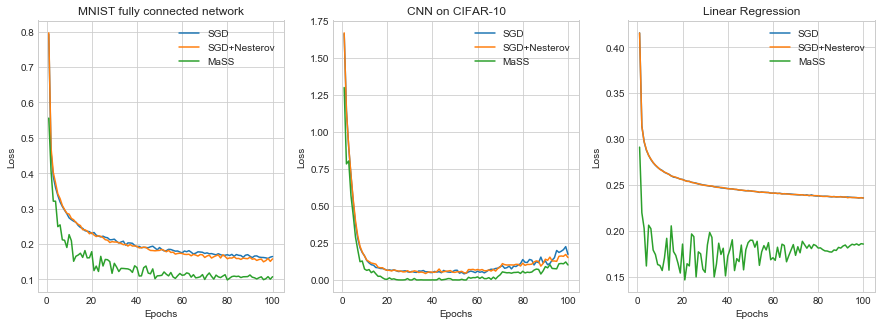

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

x = np.linspace(1, len(r_mnist_fcn_sgd_history['loss']), len(r_mnist_fcn_sgd_history['loss']))
ax[0].plot(x, r_mnist_fcn_sgd_history['loss'], label="SGD")
ax[0].plot(x, r_mnist_fcn_sgdn_history['loss'], label="SGD+Nesterov")
ax[0].plot(x, r_mnist_fcn_mass_history['loss'], label='MaSS')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("MNIST fully connected network")
ax[0].legend()

ax[1].plot(x, r_cifar_cnn_sgd_history['loss'], label="SGD")
ax[1].plot(x, r_cifar_cnn_sgdn_history['loss'], label="SGD+Nesterov")
ax[1].plot(x, r_cifar_cnn_mass_history['loss'], label='MaSS')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].set_title("CNN on CIFAR-10")
ax[1].legend()

ax[2].plot(x, r_mnist_linear_sgd_history['loss'], label="SGD")
ax[2].plot(x, r_mnist_linear_sgdn_history['loss'], label="SGD+Nesterov")
ax[2].plot(x, r_mnist_linear_mass_history['loss'], label='MaSS')
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Loss")
ax[2].set_title("Linear Regression")
ax[2].legend()

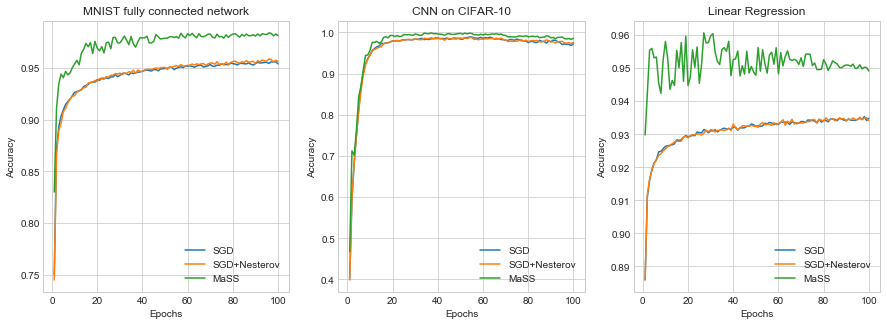

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

x = np.linspace(1, len(r_mnist_fcn_sgd_history['loss']), len(r_mnist_fcn_sgd_history['loss']))
ax[0].plot(x, r_mnist_fcn_sgd_history['accuracy'], label="SGD")
ax[0].plot(x, r_mnist_fcn_sgdn_history['accuracy'], label="SGD+Nesterov")
ax[0].plot(x, r_mnist_fcn_mass_history['accuracy'], label='MaSS')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("MNIST fully connected network")
ax[0].legend()

ax[1].plot(x, r_cifar_cnn_sgd_history['accuracy'], label="SGD")
ax[1].plot(x, r_cifar_cnn_sgdn_history['accuracy'], label="SGD+Nesterov")
ax[1].plot(x, r_cifar_cnn_mass_history['accuracy'], label='MaSS')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("CNN on CIFAR-10")
ax[1].legend()

ax[2].plot(x, r_mnist_linear_sgd_history['accuracy'], label="SGD")
ax[2].plot(x, r_mnist_linear_sgdn_history['accuracy'], label="SGD+Nesterov")
ax[2].plot(x, r_mnist_linear_mass_history['accuracy'], label='MaSS')
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Accuracy")
ax[2].set_title("Linear Regression")
ax[2].legend()

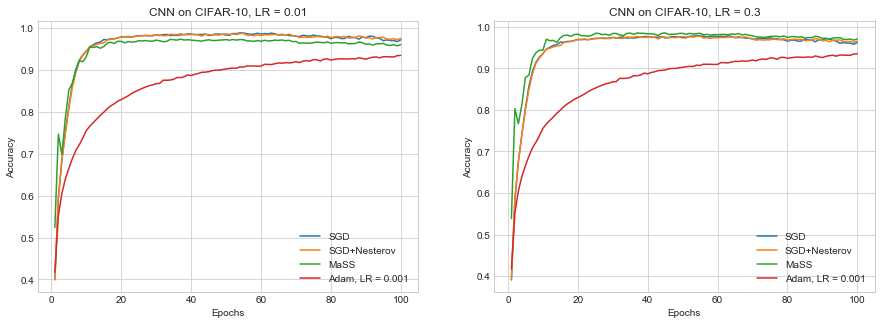

In [10]:
cnn_sgd_001 = r_cifar10_cnn_overall_results[0][0][0]['History']['accuracy']
cnn_sgdn_001 = r_cifar10_cnn_overall_results[0][1][0]['History']['accuracy']
cnn_mass_001 = r_cifar10_cnn_overall_results[0][2][0]['History']['accuracy']

cnn_sgd_03 = r_cifar10_cnn_overall_results[0][0][1]['History']['accuracy']
cnn_sgdn_03 = r_cifar10_cnn_overall_results[0][1][1]['History']['accuracy']
cnn_mass_03 = r_cifar10_cnn_overall_results[0][2][1]['History']['accuracy']

cnn_adam = r_cifar10_cnn_overall_results[0][3][0]['History']['accuracy'][:100]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

x = np.linspace(1, len(cnn_sgd_001), len(cnn_sgd_001))
ax[0].plot(x, cnn_sgd_001, label="SGD")
ax[0].plot(x, cnn_sgdn_001, label="SGD+Nesterov")
ax[0].plot(x, cnn_mass_001, label='MaSS')
ax[0].plot(x, cnn_adam, label='Adam, LR = 0.001')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("CNN on CIFAR-10, LR = 0.01")
ax[0].legend()

ax[1].plot(x, cnn_sgd_03, label="SGD")
ax[1].plot(x, cnn_sgdn_03, label="SGD+Nesterov")
ax[1].plot(x, cnn_mass_03, label='MaSS')
ax[1].plot(x, cnn_adam, label='Adam, LR = 0.001')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("CNN on CIFAR-10, LR = 0.3")
ax[1].legend()

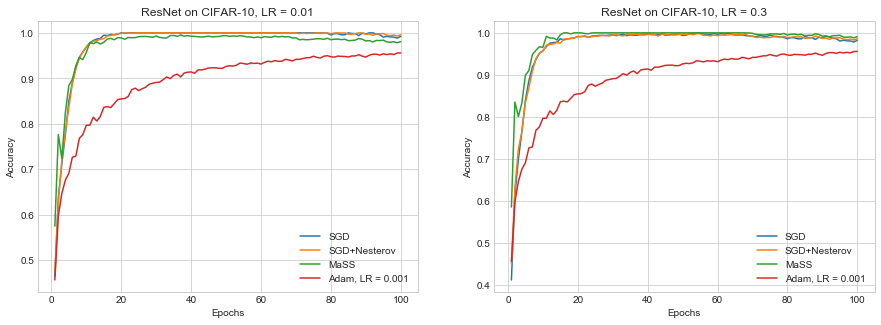

In [11]:
res_sgd_001 = r_cifar10_resnet_overall_results[0][0][0]['History']['accuracy']
res_sgdn_001 = r_cifar10_resnet_overall_results[0][1][0]['History']['accuracy']
res_mass_001 = r_cifar10_resnet_overall_results[0][2][0]['History']['accuracy']

res_sgd_03 = r_cifar10_resnet_overall_results[0][0][1]['History']['accuracy']
res_sgdn_03 = r_cifar10_resnet_overall_results[0][1][1]['History']['accuracy']
res_mass_03 = r_cifar10_resnet_overall_results[0][2][1]['History']['accuracy']

res_adam = r_cifar10_resnet_overall_results[0][3][0]['History']['accuracy'][:100]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

x = np.linspace(1, len(res_sgd_001), len(res_sgd_001))
ax[0].plot(x, res_sgd_001, label="SGD")
ax[0].plot(x, res_sgdn_001, label="SGD+Nesterov")
ax[0].plot(x, res_mass_001, label='MaSS')
ax[0].plot(x, res_adam, label='Adam, LR = 0.001')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("ResNet on CIFAR-10, LR = 0.01")
ax[0].legend()

ax[1].plot(x, res_sgd_03, label="SGD")
ax[1].plot(x, res_sgdn_03, label="SGD+Nesterov")
ax[1].plot(x, res_mass_03, label='MaSS')
ax[1].plot(x, res_adam, label='Adam, LR = 0.001')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("ResNet on CIFAR-10, LR = 0.3")
ax[1].legend()

In [283]:
print("CIFAR-10 CNN RESULTS")
print()
for i in range(len(r_cifar10_cnn_overall_results)):
    for j in range(len(r_cifar10_cnn_overall_results[i])):
        for k in range(len(r_cifar10_cnn_overall_results[i][j])):
            item = r_cifar10_cnn_overall_results[i][j][k]
            print("Optimiser:", item['Optimiser'], ", LR:", item['LR'], ", Loss:", item['Score'][0], ", Accuracy:", item['Score'][1])

print()
print("CIFAR-10 RESNET RESULTS")
print()
for i in range(len(r_cifar10_resnet_overall_results)):
    for j in range(len(r_cifar10_resnet_overall_results[i])):
        for k in range(len(r_cifar10_resnet_overall_results[i][j])):
            item = r_cifar10_resnet_overall_results[i][j][k]
            print("Optimiser:", item['Optimiser'], ", LR:", item['LR'], ", Loss:", item['Score'][0], ", Accuracy:", item['Score'][1])

CIFAR-10 CNN RESULTS

Optimiser: SGD , LR: 0.01 , Loss: 0.17288070408065823 , Accuracy: 0.9724
Optimiser: SGD , LR: 0.3 , Loss: 0.17288070408065823 , Accuracy: 0.9624007003298898
Optimiser: SGD+Nesterov , LR: 0.01 , Loss: 0.1512821618806265 , Accuracy: 0.97574
Optimiser: SGD+Nesterov , LR: 0.3 , Loss: 0.1512821618806265 , Accuracy: 0.9657423456711606
Optimiser: MaSS , LR: 0.01 , Loss: 0.6010400179906321 , Accuracy: 0.9608283267210279
Optimiser: MaSS , LR: 0.3 , Loss: 0.6010400179906321 , Accuracy: 0.9709047655941574
Optimiser: Adam , LR: 0.001 , Loss: 1.9516629796981813 , Accuracy: 0.6571000218391418

CIFAR-10 RESNET RESULTS

Optimiser: SGD , LR: 0.01 , Loss: 0.15270953463131523 , Accuracy: 0.9924135437128111
Optimiser: SGD , LR: 0.3 , Loss: 0.15277463727792084 , Accuracy: 0.9824016863542067
Optimiser: SGD+Nesterov , LR: 0.01 , Loss: 0.13113560831623436 , Accuracy: 0.9957489449079954
Optimiser: SGD+Nesterov , LR: 0.3 , Loss: 0.13122630707492638 , Accuracy: 0.985754196147457
Optimiser: 